
# Практическое задание 4. Бустинг и бэггинг

## Общая информация
Дата выдачи: 14.01.2024

Мягкий дедлайн: 28.01.2024 23:59 MSK

Жёсткий дедлайн: 04.02.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Работать мы будем на двух наборах данных: многомерных данных по кредитам с kaggle и синтетических двумерных. В данных с kaggle целевая переменная показывает, вернуло ли кредит физическое лицо:

## Импорт библиотек

In [1]:
!pip install catboost >> None
!pip install optuna >> None

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score, confusion_matrix, classification_report,  precision_score, recall_score
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, BaggingClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import LinearRegression, LogisticRegression

from typing import Type
from sklearn.base import BaseEstimator

import optuna
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm

from collections import defaultdict

## Загрузка данных

In [3]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [4]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
9159,20,student,single,high.school,no,no,no,cellular,apr,mon,...,1,999,3,failure,-1.8,93.749,-34.6,0.645,5008.7,1
2374,34,technician,divorced,professional.course,no,no,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,-1
6408,41,technician,married,professional.course,no,yes,yes,cellular,may,wed,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.270,5099.1,-1
5802,23,blue-collar,single,basic.9y,no,yes,no,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,1
7037,36,management,married,basic.6y,no,yes,yes,cellular,aug,thu,...,3,999,0,nonexistent,-2.9,92.201,-31.4,0.873,5076.2,1


Разделим на train и test (random_state не меняем)

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

Генерируем синтетические данные (seed не меняем)

In [6]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

## Utils: полезные функции

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [7]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''

    mask = np.random.choice([True, False], size=features.shape[0],
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps

    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)

    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid)[:, 1].reshape(steps, steps)
        values = (targets[mask] == 1).astype(np.float)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')

    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()

    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

In [8]:
def plot_training_curves(train_losses, val_losses, num_iterations, score, name_model):
    """
    График изображает зависимость ошибки на трейне и тесте от числа итераций
    """
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_iterations + 1), train_losses, label='Ошибка на трейне', marker='o')
    plt.plot(range(1, num_iterations + 1), val_losses, label='Ошибка на валидации', marker='o')

    # Точка минимума на ошибке валидации
    min_val_loss_idx = val_losses.index(min(val_losses))
    plt.scatter(min_val_loss_idx + 1, val_losses[min_val_loss_idx],
                color='red', label='Лучшая модель', s=100, zorder=5)

    # Укажем стрелкой максимальный скор на валидации
    plt.annotate(f'Accuracy: {score:.2%}',
                 xy=(min_val_loss_idx + 1, val_losses[min_val_loss_idx]),
                 xytext=(min_val_loss_idx + 2, val_losses[min_val_loss_idx] + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.01))

    # Оси и заголовок
    plt.xlabel('Итерации')
    plt.ylabel('Ошибка')
    plt.title(f'Ошибка модели на Train/Val: {name_model}')
    plt.legend()

    plt.show()

In [9]:
def plot_learning_curve(model, X, y):
    """
    Функция для визуализации кривой обучения в зависимости от объема тестовых данных
    """
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=3,
                                                            scoring='accuracy', n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1, 5))

    train_mean = np.mean(train_scores, axis=1)
    validation_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(7, 4))
    plt.plot(train_sizes, train_mean, label = 'Тренировочные данные')
    plt.plot(train_sizes, validation_mean, label = 'Валидационные данные')
    plt.ylabel('Доля правильных ответов', fontsize = 9)
    plt.xlabel('Размер тренировочной выборки', fontsize = 9)
    plt.title(f'Кривая обучения для модели: {type(model).__name__}', fontsize = 9, y = 1.0)
    plt.legend()
    plt.show()

In [10]:
def val_curve_params(model, X, y, param_name, param_range, scoring="accuracy", cv=3):
    """
    Функция для оценки качества модели в зависимости от числа решателей
    """
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Тренировочные данные", color='b')

    plt.plot(param_range, mean_test_score,
             label="Тестовые данные", color='g')

    plt.title(f"Валидационная кривая для {type(model).__name__}")
    plt.xlabel(f"Кол-во {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

In [11]:
def get_pred_cls_and_probs(model, X_train, X_val):
  """
  Функция для предсказания классов и вероятностей
  """
  # Предсказание классов
  y_pred_train, y_pred_val = model.predict(X_train), \
                             model.predict(X_val)

  # Предсказание вероятностей для класса 1
  y_pred_train_proba, y_pred_val_proba = model.predict_proba(X_train)[:,1], \
                                         model.predict_proba(X_val)[:,1]

  return y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba

In [12]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import roc_auc_score

def evaluate_model_classification(classifier, X_train, y_train, X_val, y_val):
  """
  Функция для отображения метрик
  """
  cm_train = confusion_matrix(y_train, classifier.predict(X_train))
  cm_val = confusion_matrix(y_val, classifier.predict(X_val))

  '''            True      False
     Positive  [0,0 (TP)  0,1 (FP)]
     Negative   [1,0 (FN)  1,1 (TN)]   '''

  TP_train, TP_val = cm_train[0,0], cm_val[0,0]
  TN_train, TN_val = cm_train[1,1], cm_val[1,1]
  FP_train, FP_val = cm_train[0,1], cm_val[0,1]
  FN_train, FN_val = cm_train[1,0], cm_val[1,0]

  precision_train, precision_val = TP_train / float(TP_train + FP_train), \
                                   TP_val / float(TP_val + FP_val)

  recall_train, recall_val = TP_train / float(TP_train + FN_train), \
                             TP_val / float(TP_val + FN_val)

  fpr_train, fpr_val = FP_train / float(FP_train + TN_train), \
                       FP_val / float(FP_val + TN_val)

  specificity_train, specificity_val = TN_train / float(TN_train + FP_train), \
                                      TN_val / float(TN_val + FP_val)

  f1_score_train, f1_score_val = 2 * (precision_train * recall_train) / (precision_train + recall_train), \
                                 2 * (precision_val * recall_val) / (precision_val + recall_val)

  ROC_AUC_train, ROC_AUC_val = roc_auc_score(y_train, y_pred_train_proba), \
                               roc_auc_score(y_val, y_pred_val_proba)

  # print('Train Support : {}'.format(dict(y_train.value_counts())))
  print("-"*50)
  print("Train Confusion Matrix:")
  print(cm_train)
  print("-"*50)
  print('Train Accuracy : {0:0.4f}'.format(accuracy_score(y_train, classifier.predict(X_train))))
  print('Train Precision : {0:0.4f}'.format(precision_train))
  print('Train Recall/Sensitivity/TPR : {0:0.4f}'.format(recall_train))
  print('Train FPR (1 - Specificity): {0:0.4f}'.format(fpr_train))
  print('Train specificity : {0:0.4f}'.format(specificity_train))
  print('Train f1-score : {0:0.4f}'.format(f1_score_train))
  print("-"*50)
  print('Train ROC AUC : {:.4f}'.format(ROC_AUC_train))

  print(" "*50)
  print(" "*50)

  # print('Val Support : {}'.format(dict(y_val.value_counts())))
  print("-"*50)
  print("Val Confusion Matrix:")
  print(cm_val)
  print("-"*50)
  print('Val Accuracy : {0:0.4f}'.format(accuracy_score(y_val, classifier.predict(X_val))))
  print('Val Precision : {0:0.4f}'.format(precision_val))
  print('Val Recall/Sensitivity/TPR : {0:0.4f}'.format(recall_val))
  print('Val FPR (1 - Specificity) : {0:0.4f}'.format(fpr_val))
  print('Val specificity : {0:0.4f}'.format(specificity_val))
  print('Val f1-score : {0:0.4f}'.format(f1_score_val))
  print("-"*50)
  print('Val ROC AUC : {:.4f}'.format(ROC_AUC_val))

In [13]:
'''
Набор функций для создания таблицы с помощью которой возможна оценка тренируемых моделей
'''

# from datetime import datetime
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# from collections import defaultdict

# Словарь для сохранения метрик моделей
results = defaultdict(lambda:{
    'model_name': 0,
    'model_type': 0,
    'model': 0,
    'scores': [{'train_scores': {
                              'train_accuracy' : 0,
                              'train_precision' : 0,
                              'train_recall' : 0,
                              'train_f1_score' : 0,
                              'train_roc_auc' : 0}
                              },
               {'val_scores': {
                              'val_accuracy' : 0,
                              'val_precision' : 0,
                              'val_recall' : 0,
                              'val_f1_score' : 0,
                              'val_roc_auc' : 0}
                              }],
})



def get_scores(y_true, y_pred, y_pred_proba):
  '''
  Посчет базовых метрик
  '''
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  roc_auc = roc_auc_score(y_true, y_pred_proba)
  return accuracy, precision, recall, f1, roc_auc


def get_results_dict(id, model_save_name, classifier, y_train, y_val, y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba):
  '''
  Наполнение рассчитанными значениями словаря results
  '''

  model_name = model_save_name
  model_type = type(classifier).__name__

  train_accuracy, train_precision, \
  train_recall, train_f1_score, \
  train_roc_auc = get_scores(y_train, y_pred_train, y_pred_train_proba)

  val_accuracy, val_precision, \
  val_recall, val_f1_score, \
  val_roc_auc = get_scores(y_val, y_pred_val, y_pred_val_proba)

  results[id]

  results[id]['model_name'] = model_name

  results[id]['model_type'] = model_type

  results[id]['model'] = classifier

  # results[id]['params'] = params

  # Тренировочные результаты
  results[id]['scores'][0]['train_scores']['train_accuracy'] = train_accuracy
  results[id]['scores'][0]['train_scores']['train_precision'] = train_precision
  results[id]['scores'][0]['train_scores']['train_recall'] = train_recall
  results[id]['scores'][0]['train_scores']['train_f1_score'] = train_f1_score
  results[id]['scores'][0]['train_scores']['train_roc_auc'] = train_roc_auc

  # Тестовые результаты
  results[id]['scores'][1]['val_scores']['val_accuracy'] = val_accuracy
  results[id]['scores'][1]['val_scores']['val_precision'] = val_precision
  results[id]['scores'][1]['val_scores']['val_recall'] = val_recall
  results[id]['scores'][1]['val_scores']['val_f1_score'] = val_f1_score
  results[id]['scores'][1]['val_scores']['val_roc_auc'] = val_roc_auc

  return results[id]


def get_results_df(results):
  '''
  Создание таблицы из словаря
  '''
  flattened_data = []
  for key, value in results.copy().items():
      results_data = {}
      results_data['Model Name'] = value['model_name']
      results_data['Model Type'] = value['model_type']
      results_data['Model'] = value['model']

      for score in value['scores']:
          if 'train_scores' in score:
              for train_score_key, train_score_value in score['train_scores'].items():
                  results_data[train_score_key] = train_score_value
          elif 'val_scores' in score:
              for val_score_key, val_score_value in score['val_scores'].items():
                  results_data[val_score_key] = val_score_value
          else:
            print('Error')

      flattened_data.append(results_data)

  results_df = pd.DataFrame(flattened_data)

  results_df = results_df[['Model Name', 'Model Type', 'Model', 'train_accuracy', \
                          'val_accuracy', 'train_precision', 'val_precision', \
                          'train_recall', 'val_recall', 'train_f1_score', \
                          'val_f1_score', 'train_roc_auc', 'val_roc_auc']]

  return results_df

## 1 Задание: (4 балла) Реализуйте бустинг для задачи бинарной классификации.

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже). Кроме того, нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

### 1.1 Ручная реализация бустинга

In [ ]:
class Boosting:

    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={},
        n_estimators: int=50,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=3
    ):
        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_early_stopping = n_iter_early_stopping

        # Плейсхолдер для нулевой модели
        self.initial_model_pred = None

        # Список для хранения весов при моделях
        self.gammas = []

        # Создаем список базовых моделей
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]

        # Loss history
        self.loss_history_train = []
        self.loss_history_val = []

        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)


    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        """

        # Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        model = self.models[n_model]
        indices = np.random.choice(len(X), size=int(self.subsample * len(X)), replace=True)
        model.fit(X[indices], y[indices])
        self.models[n_model] = model
        return model.predict(X)


    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.
        """

        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        initial_model = self.base_model_class(**self.base_model_params)
        initial_model.fit(X, y)

        self.initial_model_pred = initial_model

        pred = self.initial_model_pred.predict(X)
        return pred


    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(5, 9)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (до сигмоиды)
        :param boudnaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        # Определеяем начальные лосс и оптимальную гамму
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 100)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions - gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss

        return optimal_gamma


    def fit(self, X, y, eval_set=None):
      """
      Функция для обучения всей модели бустинга
      :param X: матрица признаков
      :param y: вектор целевой переменной
      :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
      """

      # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:


      if eval_set is None:

        old_predictions = self._fit_initial_model(X, y)

        for n_model in range(self.n_estimators):
          gradients = self.loss_derivative(y, old_predictions)
          new_predictions = self._fit_new_model(X, gradients, n_model)

          self.gammas.append(self._find_optimal_gamma(y, old_predictions, new_predictions))

          old_predictions += (-1) * self.learning_rate * self.gammas[n_model] * new_predictions

          train_loss = self.loss_fn(y, old_predictions)
          self.loss_history_train.append(train_loss)

          print(f"Iteration {n_model}, Train Loss: {train_loss:.5f}")

      else:
        X_val, y_val = eval_set

        best_validation_loss = float('inf')
        counter = 0

        old_predictions = self._fit_initial_model(X, y)
        val_predictions = self.initial_model_pred.predict(X_val) # val

        for n_model in range(self.n_estimators):
          gradients = self.loss_derivative(y, old_predictions)
          new_predictions = self._fit_new_model(X, gradients, n_model)

          model_val = self.models[n_model] # val
          pred_base_model_val = model_val.predict(X_val) # val

          self.gammas.append(self._find_optimal_gamma(y, old_predictions, new_predictions))

          old_predictions += (-1) * self.learning_rate * self.gammas[n_model] * new_predictions
          val_predictions += (-1) * self.learning_rate * self.gammas[n_model] * pred_base_model_val # val

          # Посчитаем потери на треноровке
          train_loss = self.loss_fn(y, old_predictions)
          self.loss_history_train.append(train_loss)

          # Посчитаем потери на валидации
          val_loss = self.loss_fn(y_val, val_predictions) # val
          self.loss_history_val.append(val_loss)

          print(f"Итерация {n_model}, Loss на валидации: {val_loss:.5f}")

          # Счетчик улучшения Loss на валиации
          if best_validation_loss > val_loss:
            best_validation_loss = val_loss
            counter = 0
          else:
            counter += 1

          if counter > self.n_iter_early_stopping:
            print(f"Обучение остановлено после {self.n_iter_early_stopping} итераций без улучшений на валидационной выборке.")
            break

        # Обрежем бустинг до лучшей модели
        self.n_estimators = n_model
        self.models = self.models[:n_model]

      return self


    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """

        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        probs_models = self.predict_proba(X)

        return probs_models


    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """

        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        pred = self.initial_model_pred.predict(X)
        for n_model in range(self.n_estimators):
          model = self.models[n_model]
          pred_base_model = model.predict(X)
          pred += (-1) * self.learning_rate * self.gammas[n_model] * pred_base_model

        # Получим вероятности предсказания классов прогнав предсказания модели через сигмоиду
        probs = self.sigmoid(pred)

        return probs


    @property
    def feature_importances_(self):
        """
        Для бонусного задания номер 5.
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса.
        """
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        return [model.feature_importances_ for model in self.models]

### 1.2 Проверка на синтетических данных

__Тест для вашей имплементации. Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!__

In [ ]:
%%time

boosting = Boosting(base_model_params = {'max_depth': 9,
                                         'min_samples_split': 9,
                                         'min_samples_leaf': 0.006796954853259022,
                                         'min_weight_fraction_leaf': 0.010160430543216158,
                                         'max_leaf_nodes': 332,
                                         'min_impurity_decrease': 0.0014029883138960333,
                                         'ccp_alpha': 0.0019036619617909777,
                                         'random_state': 42},
                    n_estimators=50,
                    n_iter_early_stopping=3
                    )
boosting.fit(X_train_synthetic, y_train_synthetic, eval_set=[X_test_synthetic, y_test_synthetic])
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(X_test_synthetic) > 0.5)
print(f"Accuracy_score: {accuracy_score((y_test_synthetic == 1), np.round(preds)):.3f}")
assert accuracy_score((y_test_synthetic == 1), np.round(preds)) > 0.9

Итерация 0, Loss на валидации: 0.38113
Итерация 1, Loss на валидации: 0.35838
Итерация 2, Loss на валидации: 0.34009
Итерация 3, Loss на валидации: 0.32669
Итерация 4, Loss на валидации: 0.31573
Итерация 5, Loss на валидации: 0.30706
Итерация 6, Loss на валидации: 0.29812
Итерация 7, Loss на валидации: 0.29474
Итерация 8, Loss на валидации: 0.28922
Итерация 9, Loss на валидации: 0.28594
Итерация 10, Loss на валидации: 0.28418
Итерация 11, Loss на валидации: 0.28265
Итерация 12, Loss на валидации: 0.28265
Итерация 13, Loss на валидации: 0.28265
Итерация 14, Loss на валидации: 0.28265
Итерация 15, Loss на валидации: 0.28265
Итерация 16, Loss на валидации: 0.27994
Итерация 17, Loss на валидации: 0.27994
Итерация 18, Loss на валидации: 0.27868
Итерация 19, Loss на валидации: 0.27868
Итерация 20, Loss на валидации: 0.27868
Итерация 21, Loss на валидации: 0.27868
Итерация 22, Loss на валидации: 0.27868
Обучение остановлено после 3 итераций без улучшений на валидационной выборке.
Accuracy_sco

### 1.3 Проверка на кредитных данных

__Внимание! Далее для кредитных данных будут использоваться только колонки из исходного датафрэйма с числовыми столбцами. Исходил из условия проверки.__

In [ ]:
%%time

boosting = Boosting(base_model_params = {'max_depth': 8,
                                         'min_samples_split': 2,
                                         'min_samples_leaf': 0.001112662292145572,
                                         'min_weight_fraction_leaf': 1.2894148055551816e-05,
                                         'max_leaf_nodes': 484,
                                         'min_impurity_decrease': 0.0016357004027216465,
                                         'ccp_alpha': 0.0016271300429411043},
                    n_estimators=60
                    )
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print(f"Accuracy_score: {accuracy_score((df_test.y.values == 1), np.round(preds)):.3f}")
assert accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87

Iteration 0, Train Loss: 0.41859
Iteration 1, Train Loss: 0.39868
Iteration 2, Train Loss: 0.38794
Iteration 3, Train Loss: 0.37553
Iteration 4, Train Loss: 0.36638
Iteration 5, Train Loss: 0.35654
Iteration 6, Train Loss: 0.35074
Iteration 7, Train Loss: 0.34467
Iteration 8, Train Loss: 0.33976
Iteration 9, Train Loss: 0.33492
Iteration 10, Train Loss: 0.33128
Iteration 11, Train Loss: 0.32610
Iteration 12, Train Loss: 0.32341
Iteration 13, Train Loss: 0.32227
Iteration 14, Train Loss: 0.32069
Iteration 15, Train Loss: 0.31727
Iteration 16, Train Loss: 0.31604
Iteration 17, Train Loss: 0.31526
Iteration 18, Train Loss: 0.31436
Iteration 19, Train Loss: 0.31436
Iteration 20, Train Loss: 0.31436
Iteration 21, Train Loss: 0.31327
Iteration 22, Train Loss: 0.31327
Iteration 23, Train Loss: 0.31109
Iteration 24, Train Loss: 0.31001
Iteration 25, Train Loss: 0.30942
Iteration 26, Train Loss: 0.30942
Iteration 27, Train Loss: 0.30941
Iteration 28, Train Loss: 0.30941
Iteration 29, Train Loss

### Заключение по заданию:

**Для синтетических данных:**

- Доля правильных ответов на тесте для самостоятельной реализации бустинга: `Accuracy_score: 0.913`

**Для кредитных данных:**

- Доля правильных ответов на тесте для самостоятельной реализации бустинга: `Accuracy_score: 0.879`

## 2 Задание: (2 балла) Сравните результаты вашей имплементации бустинга с указанными ниже базовыми моделями на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных.

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):

- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

Вопросы:

1) Какая из моделей имеет оптимальное качество? С чем это связано?

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

4) Визуализируйте предсказания моделей на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

In [ ]:
class boosting_algos(Boosting):
  """
  Класс boosting_algos представляет собой обертку для реализации бустинга.

  - Он предоставляет удобный интерфейс для использования бустинга с различными базовыми моделями и параметрами.
  - Позволяет выводить метрики качества алгоритма.
  - Позволяет визулизировать Loss - функцию на тренировочных и тестовых данных.

  Параметры:
  - base_model_class (Type[BaseEstimator]): Класс базовой модели.
  - base_model_params (dict): Параметры базовой модели.
  - boosting_params (dict): Параметры бустинга.
  - threshold (int): Порог классификации.

  Пример использования:
  >>> boosting_algos = boosting_algos(base_model_class=DecisionTreeRegressor,
                                      base_model_params={'max_depth': 6,
                                                         'random_state': 42},
                                      boosting_params = {'n_estimators': 5,
                                                         'n_iter_early_stopping': 5},)
  >>> boosting_algos.fit(X_train_synthetic, y_train_synthetic)
  >>> probs = boosting_algos.predict(X_test_synthetic)
  >>> dt_sint_acc, dt_sint_f1, dt_sint_auc = boosting_algos.get_score(y_test_synthetic, probs)
  """

  def __init__(
      self,
      base_model_class,
      base_model_params: dict={},
      boosting_params: dict={},
      threshold: int=0.5
  ):
      # Конструктор родительского класса (Boosting)
      super().__init__(base_model_class=base_model_class,
                       base_model_params=base_model_params,
                       **boosting_params)

      self.threshold = threshold

  def get_score(self, y_test, probabilities):
      # Вероятности
      probs = probabilities
      # Предсказания
      preds = np.round(probs > self.threshold)

      # Метрики на Test
      acc = accuracy_score((y_test == 1), np.round(preds))
      f1 = f1_score((y_test == 1), (preds == 1))
      auc = roc_auc_score((y_test == 1), probs)

      print(f"Accuracy_score: {acc:.3f}")
      print(f"f1_score: {f1:.2f}")
      print(f"AUC_score: {auc:.2f}")

      return acc, f1, auc

  def get_plot_loss(self, accuracy, title_name):
      # Визуализируем ошибку (loss)
      plot_training_curves(self.loss_history_train,
                           self.loss_history_val,
                           self.n_estimators + 1,
                           accuracy, title_name)

### 2.1 Синтетические данные



#### 2.1.1 Базовая модель: Решающее дерево глубиной 6

In [ ]:
# -> X_train_synthetic(80_000, 2) + y_train_synthetic(80_000,)
# -> X_test_synthetic(20_000, 2) + y_test_synthetic(20_000,)

In [ ]:
boost_dt_sint = boosting_algos(base_model_class=DecisionTreeRegressor,
                          base_model_params={'max_depth': 6,
                                             'random_state': 42},
                          boosting_params={'n_estimators': 50,
                                           'n_iter_early_stopping': 5}
                          )

# Обучим модель
boost_dt_sint.fit(X_train_synthetic, y_train_synthetic,
             eval_set=[X_test_synthetic, y_test_synthetic])

# Получим вероятности классов
probs = boost_dt_sint.predict(X_test_synthetic)

# Получим результаты
dt_sint_acc, dt_sint_f1, dt_sint_auc = boost_dt_sint.get_score(y_test_synthetic, probs)

Итерация 0, Loss на валидации: 0.37114
Итерация 1, Loss на валидации: 0.33932
Итерация 2, Loss на валидации: 0.31414
Итерация 3, Loss на валидации: 0.29446
Итерация 4, Loss на валидации: 0.27885
Итерация 5, Loss на валидации: 0.26680
Итерация 6, Loss на валидации: 0.25707
Итерация 7, Loss на валидации: 0.24931
Итерация 8, Loss на валидации: 0.24287
Итерация 9, Loss на валидации: 0.23619
Итерация 10, Loss на валидации: 0.23152
Итерация 11, Loss на валидации: 0.22735
Итерация 12, Loss на валидации: 0.22439
Итерация 13, Loss на валидации: 0.22090
Итерация 14, Loss на валидации: 0.21819
Итерация 15, Loss на валидации: 0.21639
Итерация 16, Loss на валидации: 0.21444
Итерация 17, Loss на валидации: 0.21175
Итерация 18, Loss на валидации: 0.21024
Итерация 19, Loss на валидации: 0.20861
Итерация 20, Loss на валидации: 0.20733
Итерация 21, Loss на валидации: 0.20635
Итерация 22, Loss на валидации: 0.20512
Итерация 23, Loss на валидации: 0.20404
Итерация 24, Loss на валидации: 0.20259
Итерация 2

#### 2.1.2 Базовая модель: Случайный лес


In [ ]:
boost_rf_sint = boosting_algos(base_model_class=RandomForestRegressor,
                          base_model_params={'max_depth': 6,
                                             'n_estimators' : 100,
                                             'random_state': 42,
                                             'n_jobs': -1},
                          boosting_params={'n_estimators': 50,
                                           'n_iter_early_stopping': 5}
                          )

# Обучим модель
boost_rf_sint.fit(X_train_synthetic, y_train_synthetic,
             eval_set=[X_test_synthetic, y_test_synthetic])

# Получим вероятности классов
probs = boost_rf_sint.predict(X_test_synthetic)

# Получим результаты
rf_sint_acc, rf_sint_f1, rf_sint_auc = boost_rf_sint.get_score(y_test_synthetic, probs)

Итерация 0, Loss на валидации: 0.36774
Итерация 1, Loss на валидации: 0.33381
Итерация 2, Loss на валидации: 0.30911
Итерация 3, Loss на валидации: 0.29037
Итерация 4, Loss на валидации: 0.27547
Итерация 5, Loss на валидации: 0.26386
Итерация 6, Loss на валидации: 0.25457
Итерация 7, Loss на валидации: 0.24671
Итерация 8, Loss на валидации: 0.23963
Итерация 9, Loss на валидации: 0.23399
Итерация 10, Loss на валидации: 0.22873
Итерация 11, Loss на валидации: 0.22431
Итерация 12, Loss на валидации: 0.22064
Итерация 13, Loss на валидации: 0.21720
Итерация 14, Loss на валидации: 0.21440
Итерация 15, Loss на валидации: 0.21187
Итерация 16, Loss на валидации: 0.20950
Итерация 17, Loss на валидации: 0.20742
Итерация 18, Loss на валидации: 0.20557
Итерация 19, Loss на валидации: 0.20389
Итерация 20, Loss на валидации: 0.20241
Итерация 21, Loss на валидации: 0.20085
Итерация 22, Loss на валидации: 0.19952
Итерация 23, Loss на валидации: 0.19821
Итерация 24, Loss на валидации: 0.19710
Итерация 2

#### 2.1.3 Базовая модель: линейная регрессия


In [ ]:
boost_lr_sint = boosting_algos(base_model_class=LinearRegression,
                          base_model_params={},
                          boosting_params={'n_estimators': 50,
                                           'n_iter_early_stopping': 5}
                          )

# Обучим модель
boost_lr_sint.fit(X_train_synthetic, y_train_synthetic,
             eval_set=[X_test_synthetic, y_test_synthetic])

# Получим вероятности классов
probs = boost_lr_sint.predict(X_test_synthetic)

# Получим результаты
lr_sint_acc, lr_sint_f1, lr_sint_auc = boost_lr_sint.get_score(y_test_synthetic, probs)

Итерация 0, Loss на валидации: 0.58047
Итерация 1, Loss на валидации: 0.57136
Итерация 2, Loss на валидации: 0.56425
Итерация 3, Loss на валидации: 0.55869
Итерация 4, Loss на валидации: 0.55432
Итерация 5, Loss на валидации: 0.55086
Итерация 6, Loss на валидации: 0.54812
Итерация 7, Loss на валидации: 0.54608
Итерация 8, Loss на валидации: 0.54440
Итерация 9, Loss на валидации: 0.54302
Итерация 10, Loss на валидации: 0.54191
Итерация 11, Loss на валидации: 0.54104
Итерация 12, Loss на валидации: 0.54032
Итерация 13, Loss на валидации: 0.53988
Итерация 14, Loss на валидации: 0.53942
Итерация 15, Loss на валидации: 0.53911
Итерация 16, Loss на валидации: 0.53885
Итерация 17, Loss на валидации: 0.53863
Итерация 18, Loss на валидации: 0.53841
Итерация 19, Loss на валидации: 0.53823
Итерация 20, Loss на валидации: 0.53814
Итерация 21, Loss на валидации: 0.53804
Итерация 22, Loss на валидации: 0.53796
Итерация 23, Loss на валидации: 0.53787
Итерация 24, Loss на валидации: 0.53781
Итерация 2

#### 2.1.4 Визуализация ошибки обучения для бустинга на базовых моделях

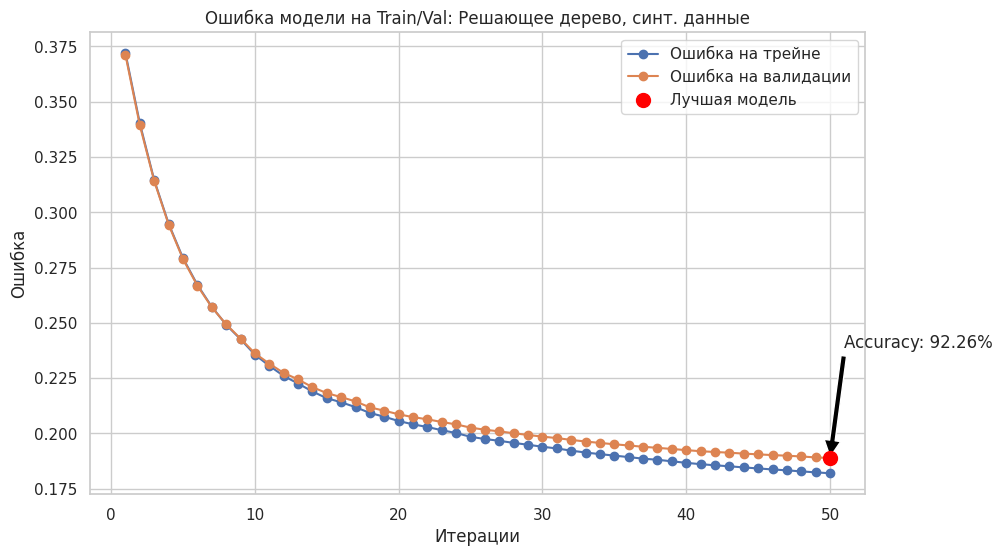

In [ ]:
# Построим график для решающего дерева
boost_dt_sint.get_plot_loss(accuracy=dt_sint_acc,
                       title_name='Решающее дерево, синт. данные')

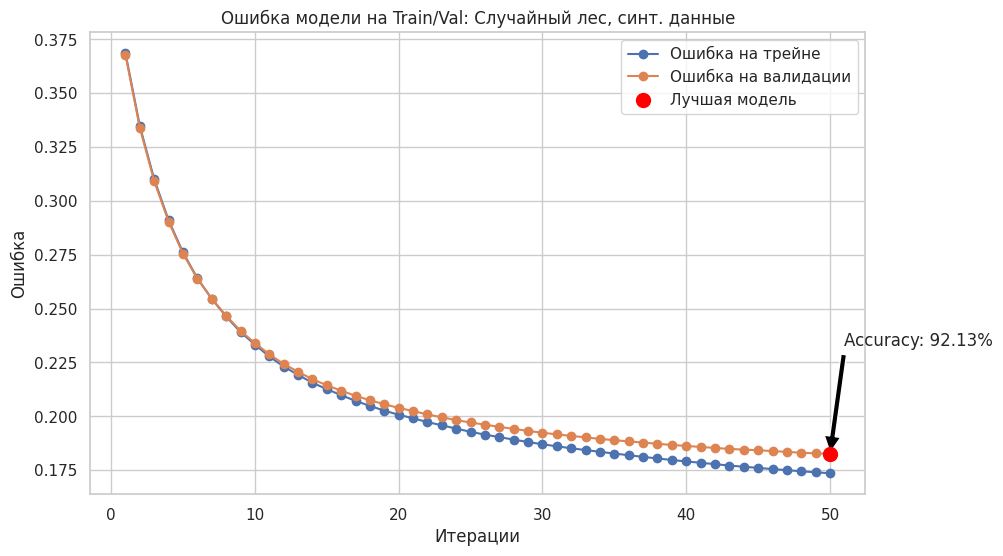

In [ ]:
# Построим график для случайного леса
boost_rf_sint.get_plot_loss(accuracy=rf_sint_acc,
                       title_name='Случайный лес, синт. данные')

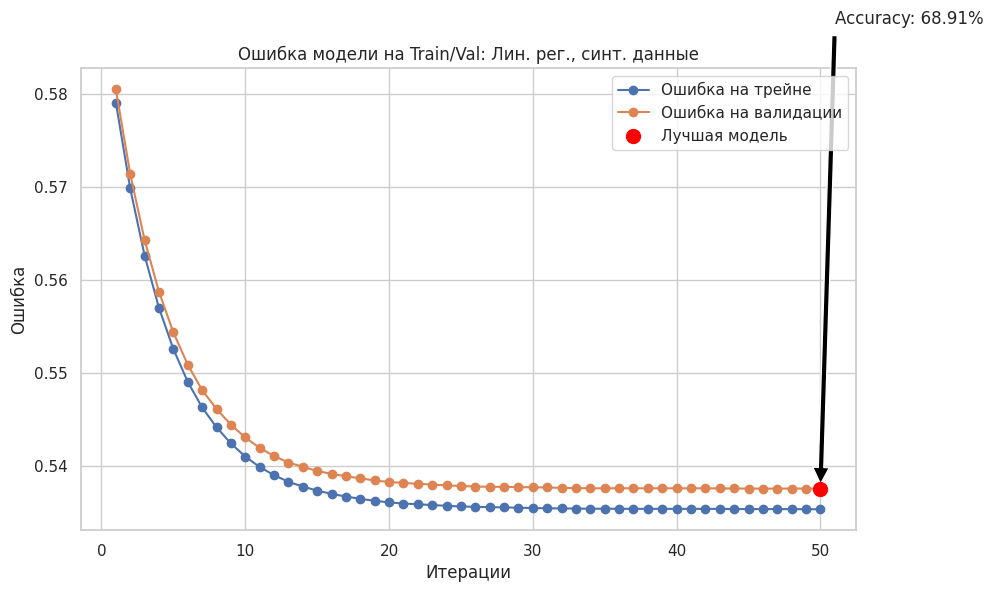

In [ ]:
# Построим график для линейной регрессии
boost_lr_sint.get_plot_loss(accuracy=lr_sint_acc,
                       title_name='Лин. рег., синт. данные')

### 2.2 Кредитные данные


In [16]:
X_train = df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values
y_train = df_train.y.values

X_test = df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values
y_test = df_test.y.values

In [ ]:
# -> X_train(7_424, 10) + y_train(7_424,)
# -> X_test(1_856, 10) + y_test(1_856,)

#### 2.2.1 Базовая модель: Решающее дерево глубиной 6

In [ ]:
boost_dt = boosting_algos(base_model_class=DecisionTreeRegressor,
                          base_model_params={'max_depth': 6,
                                             'random_state': 42},
                          boosting_params={'n_estimators': 50,
                                           'n_iter_early_stopping': 5}
                          )

# Обучим модель
boost_dt.fit(X_train, y_train,
             eval_set=[X_test, y_test])

# Получим вероятности классов
probs = boost_dt.predict(X_test)

# Получим результаты
dt_cred_acc, dt_cred_f1, dt_cred_auc = boost_dt.get_score(y_test, probs)

Итерация 0, Loss на валидации: 0.42053
Итерация 1, Loss на валидации: 0.39875
Итерация 2, Loss на валидации: 0.38306
Итерация 3, Loss на валидации: 0.37148
Итерация 4, Loss на валидации: 0.36216
Итерация 5, Loss на валидации: 0.35323
Итерация 6, Loss на валидации: 0.34590
Итерация 7, Loss на валидации: 0.33849
Итерация 8, Loss на валидации: 0.33255
Итерация 9, Loss на валидации: 0.32746
Итерация 10, Loss на валидации: 0.32301
Итерация 11, Loss на валидации: 0.31741
Итерация 12, Loss на валидации: 0.31290
Итерация 13, Loss на валидации: 0.31022
Итерация 14, Loss на валидации: 0.30747
Итерация 15, Loss на валидации: 0.30747
Итерация 16, Loss на валидации: 0.30420
Итерация 17, Loss на валидации: 0.30227
Итерация 18, Loss на валидации: 0.29994
Итерация 19, Loss на валидации: 0.29994
Итерация 20, Loss на валидации: 0.29811
Итерация 21, Loss на валидации: 0.29811
Итерация 22, Loss на валидации: 0.29682
Итерация 23, Loss на валидации: 0.29509
Итерация 24, Loss на валидации: 0.29509
Итерация 2

#### 2.2.2 Базовая модель: Случайный лес

In [ ]:
boost_rf = boosting_algos(base_model_class=RandomForestRegressor,
                          base_model_params={'max_depth': None,
                                             'n_estimators' : 100,
                                             'random_state': 42,
                                             'n_jobs': -1},
                          boosting_params={'n_estimators': 50,
                                           'n_iter_early_stopping': 5}
                          )

# Обучим модель
boost_rf.fit(X_train, y_train,
             eval_set=[X_test, y_test])

# Получим вероятности классов
probs = boost_rf.predict(X_test)

# Получим результаты
rf_cred_acc, rf_cred_f1, rf_cred_auc = boost_rf.get_score(y_test, probs)

Итерация 0, Loss на валидации: 0.40109
Итерация 1, Loss на валидации: 0.37377
Итерация 2, Loss на валидации: 0.35324
Итерация 3, Loss на валидации: 0.33849
Итерация 4, Loss на валидации: 0.32693
Итерация 5, Loss на валидации: 0.32001
Итерация 6, Loss на валидации: 0.31179
Итерация 7, Loss на валидации: 0.30624
Итерация 8, Loss на валидации: 0.30152
Итерация 9, Loss на валидации: 0.29785
Итерация 10, Loss на валидации: 0.29456
Итерация 11, Loss на валидации: 0.29183
Итерация 12, Loss на валидации: 0.29033
Итерация 13, Loss на валидации: 0.28785
Итерация 14, Loss на валидации: 0.28650
Итерация 15, Loss на валидации: 0.28555
Итерация 16, Loss на валидации: 0.28459
Итерация 17, Loss на валидации: 0.28393
Итерация 18, Loss на валидации: 0.28292
Итерация 19, Loss на валидации: 0.28201
Итерация 20, Loss на валидации: 0.28123
Итерация 21, Loss на валидации: 0.28064
Итерация 22, Loss на валидации: 0.27969
Итерация 23, Loss на валидации: 0.27915
Итерация 24, Loss на валидации: 0.27896
Итерация 2

#### 2.2.3 Базовая модель: линейная регрессия

In [ ]:
boost_lr = boosting_algos(base_model_class=LinearRegression,
                          base_model_params={},
                          boosting_params={'n_estimators': 50,
                                           'n_iter_early_stopping': 5}
                          )

# Обучим модель
boost_lr.fit(X_train, y_train,
             eval_set=[X_test, y_test])

# Получим вероятности классов
probs = boost_lr.predict(X_test)

# Получим результаты
lr_cred_acc, lr_cred_f1, lr_cred_auc = boost_lr.get_score(y_test, probs)

Итерация 0, Loss на валидации: 0.47778
Итерация 1, Loss на валидации: 0.45542
Итерация 2, Loss на валидации: 0.43929
Итерация 3, Loss на валидации: 0.42685
Итерация 4, Loss на валидации: 0.41840
Итерация 5, Loss на валидации: 0.41028
Итерация 6, Loss на валидации: 0.40251
Итерация 7, Loss на валидации: 0.39665
Итерация 8, Loss на валидации: 0.39189
Итерация 9, Loss на валидации: 0.38720
Итерация 10, Loss на валидации: 0.38381
Итерация 11, Loss на валидации: 0.38015
Итерация 12, Loss на валидации: 0.37776
Итерация 13, Loss на валидации: 0.37530
Итерация 14, Loss на валидации: 0.37281
Итерация 15, Loss на валидации: 0.37090
Итерация 16, Loss на валидации: 0.36895
Итерация 17, Loss на валидации: 0.36740
Итерация 18, Loss на валидации: 0.36639
Итерация 19, Loss на валидации: 0.36557
Итерация 20, Loss на валидации: 0.36447
Итерация 21, Loss на валидации: 0.36378
Итерация 22, Loss на валидации: 0.36293
Итерация 23, Loss на валидации: 0.36192
Итерация 24, Loss на валидации: 0.36143
Итерация 2

#### 2.2.4 Визуализация ошибки обучения для бустинга на базовых моделях

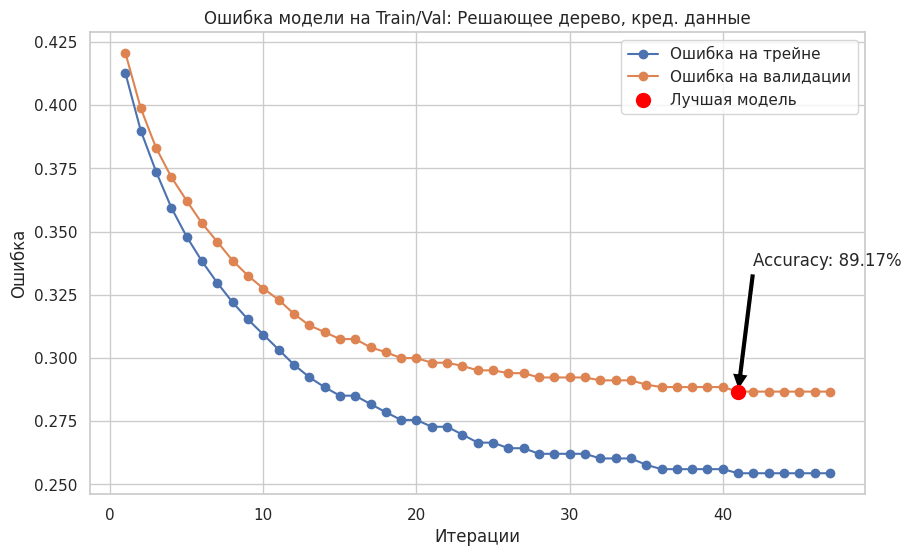

In [ ]:
# Построим график для решающего дерева
boost_dt.get_plot_loss(accuracy=dt_cred_acc,
                       title_name='Решающее дерево, кред. данные')

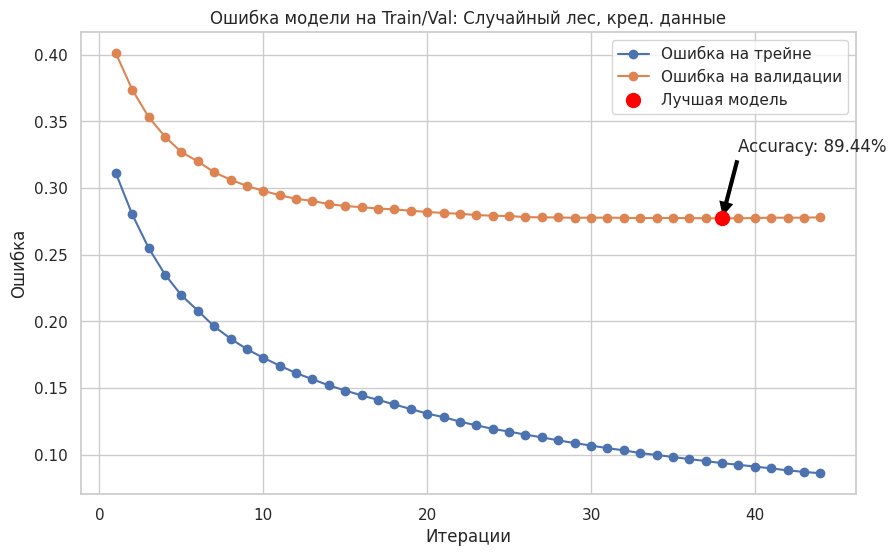

In [ ]:
# Построим график для случайного леса
boost_rf.get_plot_loss(accuracy=rf_cred_acc,
                       title_name='Случайный лес, кред. данные')

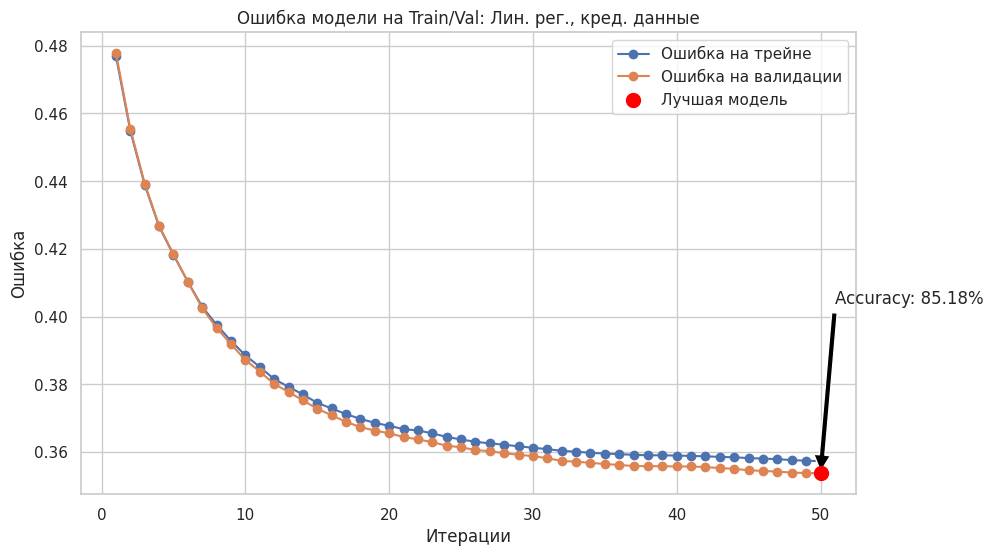

In [ ]:
# Построим график для линейной регрессии
boost_lr.get_plot_loss(accuracy=lr_cred_acc,
                       title_name='Лин. рег., кред. данные')

### 2.3 Ответы на Вопросы:

#### 2.2.1 1) Какая из моделей имеет оптимальное качество? С чем это связано?

In [ ]:
columns=['Model Name', 'accuracy', 'f1', 'AUC']

df_sint_score = pd.DataFrame(columns=columns)
df_cred_score = pd.DataFrame(columns=columns)

In [ ]:
new_rows_sint = [
    pd.Series({'Model Name': 'DecisionTreeRegressor', 'accuracy': dt_sint_acc, 'f1': dt_sint_f1, 'AUC': dt_sint_auc}),
    pd.Series({'Model Name': 'RandomForestRegressor', 'accuracy': rf_sint_acc, 'f1': rf_sint_f1, 'AUC': rf_sint_auc}),
    pd.Series({'Model Name': 'LinearRegression', 'accuracy': lr_sint_acc, 'f1': lr_sint_f1, 'AUC': lr_sint_auc})
]

new_rows_cred = [
    pd.Series({'Model Name': 'DecisionTreeRegressor', 'accuracy': dt_cred_acc, 'f1': dt_cred_f1, 'AUC': dt_cred_auc}),
    pd.Series({'Model Name': 'RandomForestRegressor', 'accuracy': rf_cred_acc, 'f1': rf_cred_f1, 'AUC': rf_cred_auc}),
    pd.Series({'Model Name': 'LinearRegression', 'accuracy': lr_cred_acc, 'f1': lr_cred_f1, 'AUC': lr_cred_auc})
]

In [ ]:
df_sint_score = pd.concat([df_sint_score, pd.DataFrame(new_rows_sint)], ignore_index=True)
df_cred_score = pd.concat([df_cred_score, pd.DataFrame(new_rows_cred)], ignore_index=True)

In [ ]:
# Модели обученные на синтетических данных
df_sint_score.sort_values(by='accuracy', ascending=False)

,Model Name,accuracy,f1,AUC
0,DecisionTreeRegressor,0.92260,0.924628,0.982101
1,RandomForestRegressor,0.92130,0.923264,0.982560
2,LinearRegression,0.68905,0.691380,0.797646


In [ ]:
# Модели обученные на кредитных данных
df_cred_score.sort_values(by='accuracy', ascending=False)

,Model Name,accuracy,f1,AUC
1,RandomForestRegressor,0.894397,0.894850,0.947823
0,DecisionTreeRegressor,0.891703,0.892571,0.950949
2,LinearRegression,0.851832,0.848652,0.928160


Как видим, на двух наборах данных, наилучший результат у градиентного бустинга с базовой моделью - случайный лес, на равне идет дерево и худшие метрики у линейной регрессии.
- Базовый алгоритмом RandomForestRegressor дает не плохой результат, что может указывать на его более высокую способность к обобщению на новые данные. Обычно, ансамбль деревьев решений обеспечивает хорошую способность к обобщению и устойчивость к переобучению.
- Линейная регрессия подразумевает линейные зависимости между признаками и целевой переменной. Если данные имеют сложные нелинейные зависимости, линейная регрессия может не быть достаточно гибкой, чтобы их улавливать. В данном случае имеет саму низкую точность.


#### 2.2.2 2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

Да, отслеживания переобучения я использовал графики функции потерь (Loss) от числа итераций градиентного бустинга для обучающих (Train) и валидационных (Val) данных.
Визуально, момент переобучения можно интерпретировать следующим образом:
- Если Train Loss стремится к нулю, а Val Loss не улучшается или даже начинает расти, это может свидетельствовать о переобучении. Модель "запоминает" обучающие данные, но не обобщает хорошо на новые данные. В моем случае работает ранняя остановка, которая прекращет обучение модели, когда происходит переобучение, т.е когда качество на валидационных данных перестает улучшаться. Так же, помимо `n_iter_early_stopping`, в ручную можно задавать параметр отвечающий за максимальное число итераций бустинга `n_estimators`, суть которого заключалась в ограничении числа базовых моделей ансамбля.
- Так же увеличение разрыва между Train Loss и Val Loss является признаком переобучения.

К примеру на кредитных данных - сильнее всего переобучилась модель бустинга на дереве. У случайного леса как правило меньше склонность к переобучению и лучше обобщающая способность, однако на валидационной выборке оба алгоритма показали сопоставимый результат.

Линейная же модель показала точность ниже чем у деревьев, но меньше всего подстроилась под тренировочные данные, получила большую обобщающую способность.

#### 2.2.3 3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

__Синтетические данные__

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_synthetic, y_train_synthetic)

LogisticRegression()

In [ ]:
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(logreg, X_train_synthetic, X_test_synthetic)

In [ ]:
# Оценка точности логистической регрессии
print('Точность на тренировочных данных: {:.4f}'.format(accuracy_score(y_train_synthetic, y_pred_train)))
print('Точность на тестовых данных: {:.4f}'.format(accuracy_score(y_test_synthetic, y_pred_val)))

Точность на тренировочных данных: 0.6926
Точность на тестовых данных: 0.6891


In [ ]:
# Оценка точности бустинга на лин. рег.
print('Точность на тестовых данных бустинга на линейной регрессии: {:.4f}'.format(lr_sint_acc))

Точность на тестовых данных бустинга на линейной регрессии: 0.6891


__Кредитные данные__

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(logreg, X_train, X_test)

# Оценка точности логистической регрессии
print('Точность на тренировочных данных: {:.4f}'.format(accuracy_score(y_train, y_pred_train)))
print('Точность на тестовых данных: {:.4f}'.format(accuracy_score(y_test, y_pred_val)))

Точность на тренировочных данных: 0.8521
Точность на тестовых данных: 0.8464


In [ ]:
# Оценка точности бустинга на лин. рег.
print('Точность на тестовых данных бустинга на линейной регрессии: {:.4f}'.format(lr_cred_acc))

Точность на тестовых данных бустинга на линейной регрессии: 0.8518


Исходя из полученных данных: бустинг над линейными регрессиями работает практически так же, как и одна логистическая регрессия. Результаты сопоставимы.
- Такой результат говорит о том, что бустинг над линейными регрессиями добавляет сложность модели, но при этом точность на новых данных не растет.
- Характер данных так же не совсем линейный (Х от у) и одна линейная модель сопоставима по точности с композицией линейных моделей. Т. е. у линейной модели отсутствует возможность поиска глубоких зависимостей признаков от целевой переменной, в отоличие от деревьев.
- Результаты бустинга зависят от гиперпараметров, которые установленны по дефолту, возможно нужно обратить на них внимание.

#### 2.2.4 4) Визуализируйте предсказания моделей на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

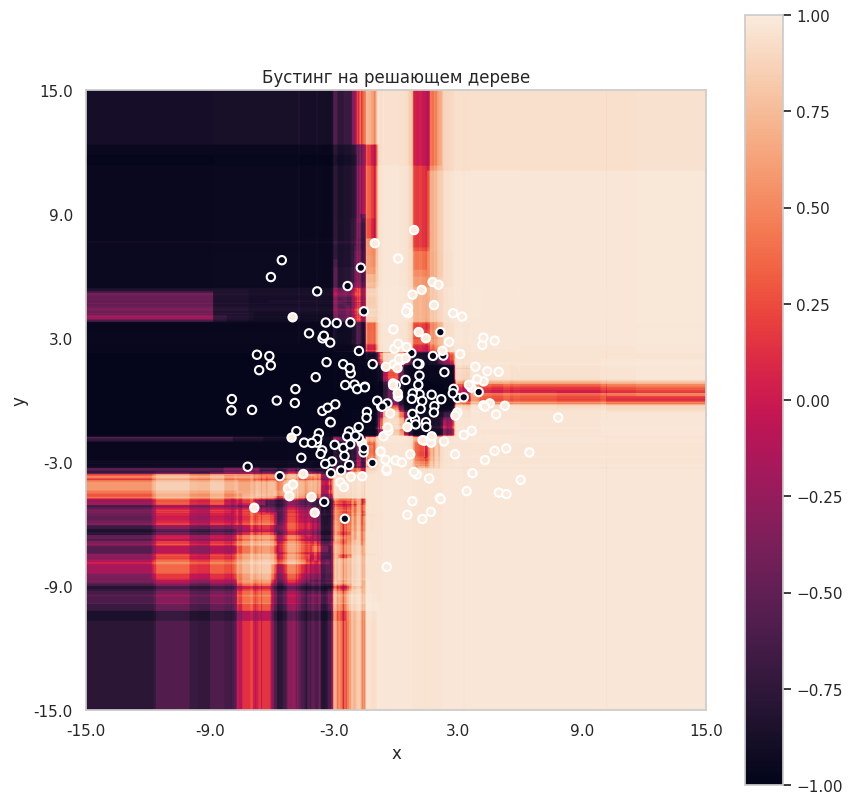

In [ ]:
# Визуализируем бустинг на решающем дереве
plot_predicts(boost_dt_sint, X_test_synthetic, y_test_synthetic,
              x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
              examples_density=0.01, steps=1000, num_ticks=6, title='Бустинг на решающем дереве', mode='regression')

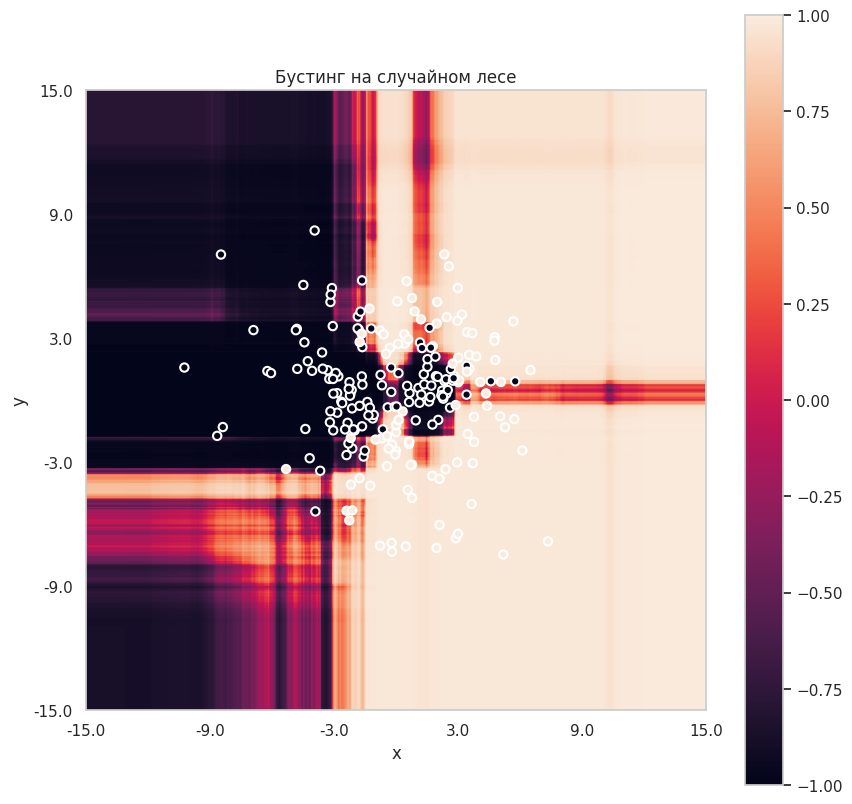

In [ ]:
# Визуализируем бустинг на случайном лесе
plot_predicts(boost_rf_sint, X_test_synthetic, y_test_synthetic,
              x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
              examples_density=0.01, steps=1000, num_ticks=6, title='Бустинг на случайном лесе', mode='regression')

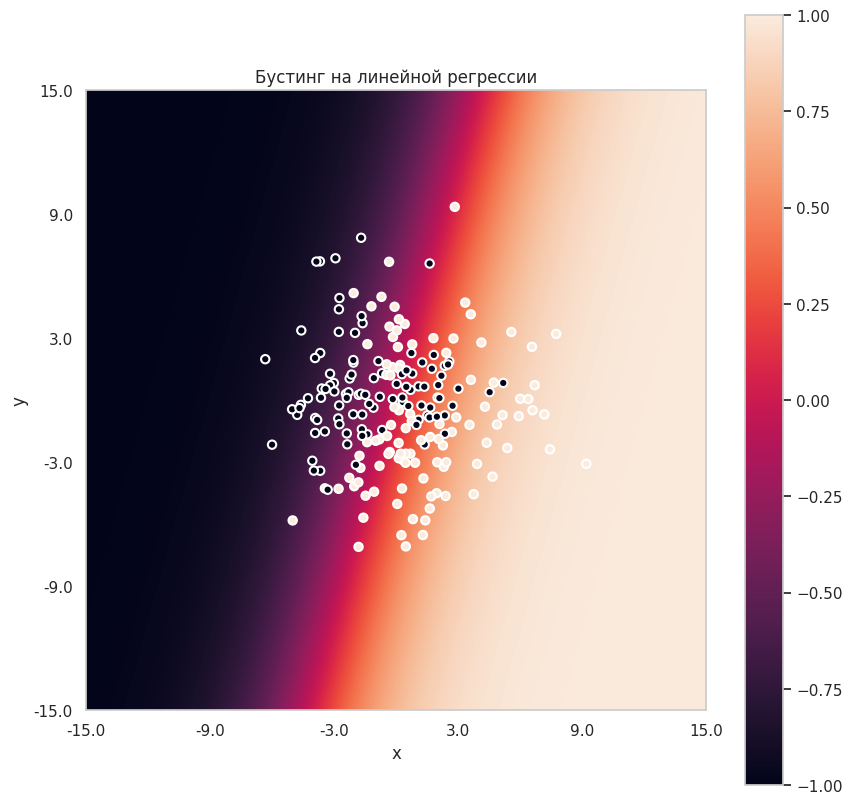

In [ ]:
# Визуализируем бустинг на линейной регрессии
plot_predicts(boost_lr_sint, X_test_synthetic, y_test_synthetic,
              x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
              examples_density=0.01, steps=1000, num_ticks=6, title='Бустинг на линейной регрессии', mode='regression')

Функция предназначена для визуализации работы модели на двумерных данных, позволяя оценить, как модель делает предсказания на двумерной плоскости.
- Решающее дерево строит разделяющие гиперплоскости, вертикальные и горизонтальные линиями, параллельные осям. Т.к. дерево не глубокое, видны четкие границы областей охватывающие положительные классы. Однако признаки переобучения присутствуют, как будто дерево запомнило обучающую структуру данных в определенных местах.
- Границы решений случайного леса в данном случае более четкие, т.к сам по себе ансамбль леса имеет лучшую по сравнению с одним деревом обобщающую способность.
- Линейная регрессия строит линейную гиперплоскость, которая разделяет классы. Является в данном случае самым слабым алгоритмом. Т. к признаки не линейны от целевой переменной.

## 3 Задание: (2 балла) Мы разобрались с бустингом, теперь интересно посмотреть на совсем дикие комбинации моделей. Сравните результаты следующих моделей на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных.

Используйте логистическую регрессию, случайный лес и BaggingClassifier из sklearn.

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков (`max_features` около 0.6 в BaggingClassifier)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

1) Какая из моделей имеет лучшее качество? С чем это связано?

2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка?

3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?

4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?

5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?

### 3.1 Синтетические данные

In [ ]:
# Соберем данные
X_synthetic = np.concatenate((X_train_synthetic, X_test_synthetic), axis=0)
y_synthetic = np.concatenate((y_train_synthetic, y_test_synthetic), axis=0)

#### 3.1.1 Случайный лес

In [ ]:
rf = RandomForestClassifier(max_depth=12, random_state=0)
rf.fit(X_train_synthetic, y_train_synthetic)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(rf, X_train_synthetic, X_test_synthetic)

In [ ]:
# Оценим метрики На Test
print(classification_report(y_test_synthetic, y_pred_val))

              precision    recall  f1-score   support

        -1.0       0.93      0.91      0.92      9855
         1.0       0.91      0.93      0.92     10145

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



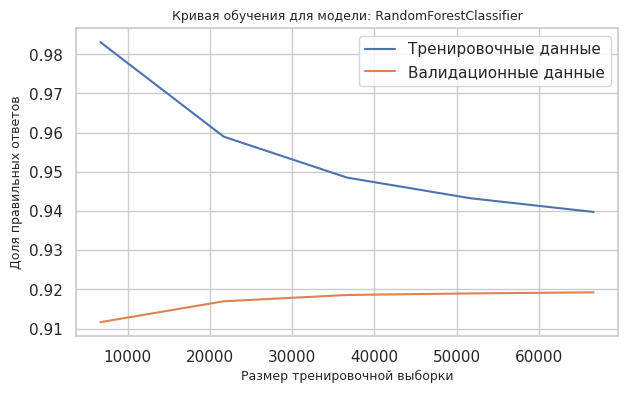

In [ ]:
plot_learning_curve(rf, X_synthetic, y_synthetic)

#### 3.1.2 Бэггинг на деревьях (min_samples_leaf=1)

In [ ]:
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=12, min_samples_leaf=1),
                               n_estimators=50,
                               random_state=0)
bagging_dt.fit(X_train_synthetic, y_train_synthetic)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt, X_train_synthetic, X_test_synthetic)

In [ ]:
# Оценим метрики На Test
print(classification_report(y_test_synthetic, y_pred_val))

              precision    recall  f1-score   support

        -1.0       0.93      0.91      0.92      9855
         1.0       0.91      0.93      0.92     10145

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



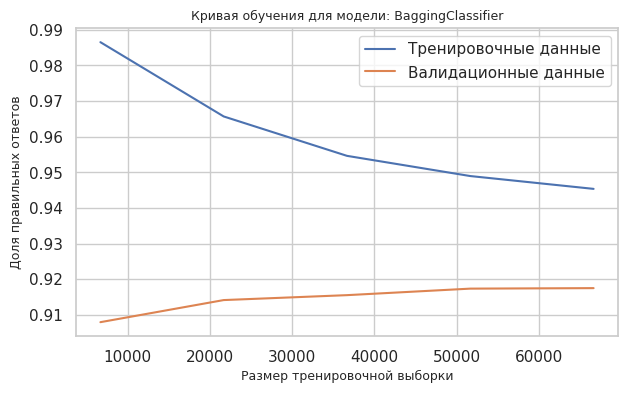

In [ ]:
plot_learning_curve(bagging_dt, X_synthetic, y_synthetic)

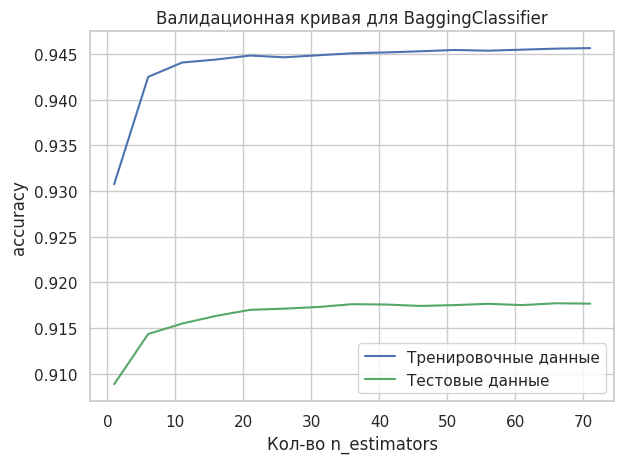

In [ ]:
val_curve_params(bagging_dt, X_synthetic, y_synthetic, "n_estimators", range(1,75,5), cv=3)

#### 3.1.3 Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков (max_features около 0.6 в BaggingClassifier)

In [ ]:
bagging_dt_max_features = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                                            n_estimators=50,
                                            max_features=0.6,
                                            random_state=0)
bagging_dt_max_features.fit(X_train_synthetic, y_train_synthetic)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt_max_features, X_train_synthetic, X_test_synthetic)

In [ ]:
# Оценим метрики На Test
print(classification_report(y_test_synthetic, y_pred_val))

              precision    recall  f1-score   support

        -1.0       0.92      0.90      0.91      9855
         1.0       0.91      0.93      0.92     10145

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



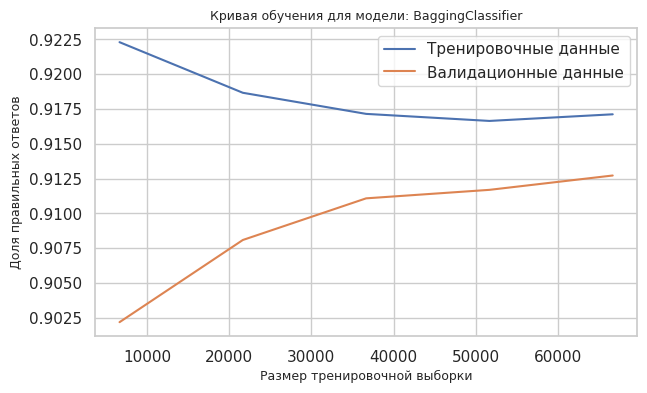

In [ ]:
plot_learning_curve(bagging_dt_max_features, X_synthetic, y_synthetic)

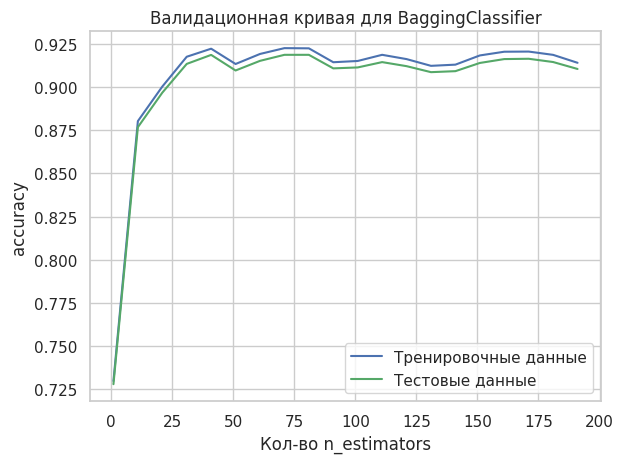

In [ ]:
val_curve_params(bagging_dt_max_features, X_synthetic, y_synthetic, "n_estimators", range(1,200,10), cv=3)

#### 3.1.4 Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)

In [ ]:
boost_rf_sint_for_bagging = GradientBoostingClassifier(n_estimators=101,
                                                       max_depth=6,
                                                       random_state=0)

In [ ]:
bagging_dt_boosting = BaggingClassifier(estimator=boost_rf_sint_for_bagging,
                                        n_estimators=50,
                                        random_state=0)
bagging_dt_boosting.fit(X_train_synthetic, y_train_synthetic)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt_boosting, X_train_synthetic, X_test_synthetic)

In [ ]:
# Оценим метрики На Test
print(classification_report(y_test_synthetic, y_pred_val))

              precision    recall  f1-score   support

        -1.0       0.93      0.91      0.92      9855
         1.0       0.92      0.93      0.92     10145

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



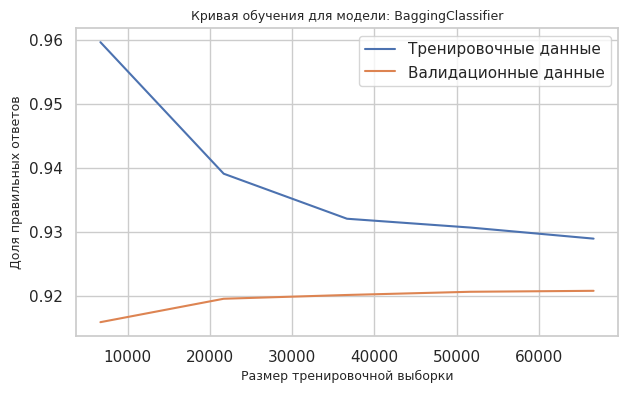

In [ ]:
plot_learning_curve(bagging_dt_boosting, X_synthetic, y_synthetic)

In [ ]:
# val_curve_params(bagging_dt_boosting, X_synthetic, y_synthetic, "n_estimators", range(1,200,3), cv=3)

#### 3.1.5 Бэггинг на логистических регрессиях

In [ ]:
bagging_lr = BaggingClassifier(estimator=LogisticRegression(),
                                         n_estimators=50,
                                         random_state=0)
bagging_lr.fit(X_train_synthetic, y_train_synthetic)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_lr, X_train_synthetic, X_test_synthetic)

In [ ]:
# Оценим метрики На Test
print(classification_report(y_test_synthetic, y_pred_val))

              precision    recall  f1-score   support

        -1.0       0.68      0.69      0.69      9855
         1.0       0.70      0.69      0.69     10145

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000



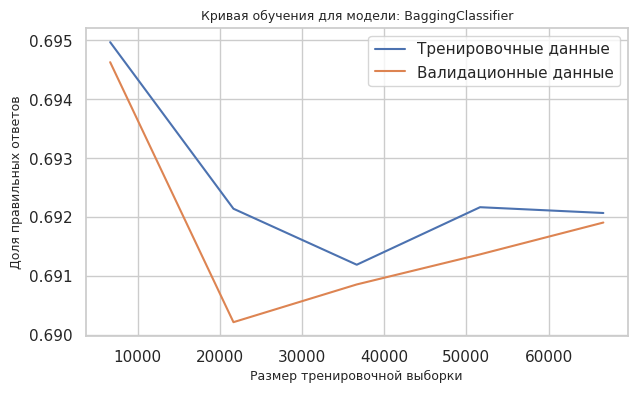

In [ ]:
plot_learning_curve(bagging_lr, X_synthetic, y_synthetic)

In [ ]:
# val_curve_params(bagging_lr, X_synthetic, y_synthetic, "n_estimators", range(1,200,5), cv=3)

#### Ответы на вопросы

__1) Какая из моделей имеет лучшее качество? С чем это связано?__

- Самое лучшее качество имеет модель дерева, которе является базовой моделью случайного леса, который является базовой моделью бустинга, который, в свою очередь, является базовой моделью бэггинга ))
- Связанно с тем что бустинг на случайном лесе представляет хорошую базовую модель для бэггинга (далее вся эта комбинация - модель) в плане того, что каждая модель обучается независимо, на бустрапированных подвыборках данных + на случайном подмножестве всех признаков, что приводит к разнообразию моделей и улучшению их обобщающей способности.
- А бустинг, к тому же, обучается на ошибках предыдущих моделей своей композиции, что позволяет ему скорректировать ошибки предыдущих моделей.
- В целом бэггинг на бустинге из случайного леса может создавать разнообразные базовые модели, что положительно сказывается на обобщающей способности. Где бустинг сильнее сфокусирован на уменьшении ошибок предыдущих моделей случайного леса.

__2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка?__

- Если дерево не ограничивать по глубине, то оно быстро переобучается. Выражается это в максимальной подгонке под обучающиеся данные, и получение на тесте заметно хучших метрик.
- Беггинг на линейной регрессии так же имеет высокую склонность к переобучению среди рассмотренных моеделй с кол-вом базовых моделей более 130.
- Ранняя остановка бустингу безусловно помогает, когда добавление новых базовых моделей не улучшает производительность на валидационных даннных. Следовательно необходимо вовремя останавливать обучение, в момент, когда на валидации метрики перестают расти.

__3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?__

In [ ]:
# Обучим бустинг с большим числом деревьев
boost_rf_sint_for_bagging_v2 = GradientBoostingClassifier(n_estimators=300,
                                                          max_depth=6,
                                                          random_state=0)

boost_rf_sint_for_bagging_v2.fit(X_train_synthetic, y_train_synthetic)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(boost_rf_sint_for_bagging_v2, X_train_synthetic, X_test_synthetic)

In [ ]:
evaluate_model_classification(boost_rf_sint_for_bagging_v2, X_train_synthetic, y_train_synthetic, X_test_synthetic, y_test_synthetic)

--------------------------------------------------
Train Confusion Matrix:
[[37208  2763]
 [ 2209 37820]]
--------------------------------------------------
Train Accuracy : 0.9378
Train Precision : 0.9309
Train Recall/Sensitivity/TPR : 0.9440
Train FPR (1 - Specificity): 0.0681
Train specificity : 0.9319
Train f1-score : 0.9374
--------------------------------------------------
Train ROC AUC : 0.9893
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[8992  863]
 [ 686 9459]]
--------------------------------------------------
Val Accuracy : 0.9225
Val Precision : 0.9124
Val Recall/Sensitivity/TPR : 0.9291
Val FPR (1 - Specificity) : 0.0836
Val specificity : 0.9164
Val f1-score : 0.9207
--------------------------------------------------
Val ROC AUC : 0.9827


In [ ]:
# Обучим бэггинг на бустинге
bagging_dt_boosting_v2 = BaggingClassifier(estimator=boost_rf_sint_for_bagging_v2,
                                           n_estimators=3,
                                           random_state=0)
bagging_dt_boosting_v2.fit(X_train_synthetic, y_train_synthetic)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt_boosting_v2, X_train_synthetic, X_test_synthetic)

In [ ]:
evaluate_model_classification(bagging_dt_boosting_v2, X_train_synthetic, y_train_synthetic, X_test_synthetic, y_test_synthetic)

--------------------------------------------------
Train Confusion Matrix:
[[37115  2856]
 [ 2299 37730]]
--------------------------------------------------
Train Accuracy : 0.9356
Train Precision : 0.9285
Train Recall/Sensitivity/TPR : 0.9417
Train FPR (1 - Specificity): 0.0704
Train specificity : 0.9296
Train f1-score : 0.9351
--------------------------------------------------
Train ROC AUC : 0.9887
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[8977  878]
 [ 672 9473]]
--------------------------------------------------
Val Accuracy : 0.9225
Val Precision : 0.9109
Val Recall/Sensitivity/TPR : 0.9304
Val FPR (1 - Specificity) : 0.0848
Val specificity : 0.9152
Val f1-score : 0.9205
--------------------------------------------------
Val ROC AUC : 0.9829


- Бэггинг может помочь уменьшить переобученность, особенно если используется большое количество деревьев. Т. к. усредненяет прогнозы базовых моделей, обученных на различных подмножествах данных.
- В данном случае нужно запустить бэггинг хотя-бы на 100 базовых моделях. Но считается это очень долго. На трех базовых моделях видим что качество бэггинга на трейне немного стало ниже бустинга, а на тесте немного возрасло.

__4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?__

В нашем случае по качеству модели выигрывает случайный лес - по метрике accuracy. Но результаты вполне сопоставимы

In [ ]:
# Бэггинг на деревьях с сэмплированием признаков
evaluate_model_classification(bagging_dt, X_train_synthetic, y_train_synthetic, X_test_synthetic, y_test_synthetic)

--------------------------------------------------
Train Confusion Matrix:
[[37345  2626]
 [ 2007 38022]]
--------------------------------------------------
Train Accuracy : 0.9421
Train Precision : 0.9343
Train Recall/Sensitivity/TPR : 0.9490
Train FPR (1 - Specificity): 0.0646
Train specificity : 0.9354
Train f1-score : 0.9416
--------------------------------------------------
Train ROC AUC : 0.9887
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[8953  902]
 [ 705 9440]]
--------------------------------------------------
Val Accuracy : 0.9196
Val Precision : 0.9085
Val Recall/Sensitivity/TPR : 0.9270
Val FPR (1 - Specificity) : 0.0872
Val specificity : 0.9128
Val f1-score : 0.9176
--------------------------------------------------
Val ROC AUC : 0.9829


In [ ]:
# Случайный лес
evaluate_model_classification(rf, X_train_synthetic, y_train_synthetic, X_test_synthetic, y_test_synthetic)

--------------------------------------------------
Train Confusion Matrix:
[[37039  2932]
 [ 2171 37858]]
--------------------------------------------------
Train Accuracy : 0.9362
Train Precision : 0.9266
Train Recall/Sensitivity/TPR : 0.9446
Train FPR (1 - Specificity): 0.0719
Train specificity : 0.9281
Train f1-score : 0.9356
--------------------------------------------------
Train ROC AUC : 0.9887
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[8957  898]
 [ 680 9465]]
--------------------------------------------------
Val Accuracy : 0.9211
Val Precision : 0.9089
Val Recall/Sensitivity/TPR : 0.9294
Val FPR (1 - Specificity) : 0.0867
Val specificity : 0.9133
Val f1-score : 0.9190
--------------------------------------------------
Val ROC AUC : 0.9829


__5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?__

В нашем случае по качеству модели выигрывает бустинг на деревьях - по метрике accuracy.
- Бустинг фокусируется на улучшении модели за счет последовательного обучения слабых моделей.
- Бэггинг же просто усредняет прогнозы всех базовых моделей.

In [ ]:
# Бэггинг на деревьях
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                                            n_estimators=50,
                                            random_state=0)
bagging_dt.fit(X_train_synthetic, y_train_synthetic)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt, X_train_synthetic, X_test_synthetic)

In [ ]:
evaluate_model_classification(bagging_dt, X_train_synthetic, y_train_synthetic, X_test_synthetic, y_test_synthetic)

--------------------------------------------------
Train Confusion Matrix:
[[34980  4991]
 [ 2646 37383]]
--------------------------------------------------
Train Accuracy : 0.9045
Train Precision : 0.8751
Train Recall/Sensitivity/TPR : 0.9297
Train FPR (1 - Specificity): 0.1178
Train specificity : 0.8822
Train f1-score : 0.9016
--------------------------------------------------
Train ROC AUC : 0.9736
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[8586 1269]
 [ 657 9488]]
--------------------------------------------------
Val Accuracy : 0.9037
Val Precision : 0.8712
Val Recall/Sensitivity/TPR : 0.9289
Val FPR (1 - Specificity) : 0.1180
Val specificity : 0.8820
Val f1-score : 0.8992
--------------------------------------------------
Val ROC AUC : 0.9740


In [ ]:
evaluate_model_classification(boost_rf_sint_for_bagging_v2, X_train_synthetic, y_train_synthetic, X_test_synthetic, y_test_synthetic)

--------------------------------------------------
Train Confusion Matrix:
[[37208  2763]
 [ 2209 37820]]
--------------------------------------------------
Train Accuracy : 0.9378
Train Precision : 0.9309
Train Recall/Sensitivity/TPR : 0.9440
Train FPR (1 - Specificity): 0.0681
Train specificity : 0.9319
Train f1-score : 0.9374
--------------------------------------------------
Train ROC AUC : 0.9736
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[8992  863]
 [ 686 9459]]
--------------------------------------------------
Val Accuracy : 0.9225
Val Precision : 0.9124
Val Recall/Sensitivity/TPR : 0.9291
Val FPR (1 - Specificity) : 0.0836
Val specificity : 0.9164
Val f1-score : 0.9207
--------------------------------------------------
Val ROC AUC : 0.9740


### 3.2 Кредитные данные

#### 3.1.1 Случайный лес

In [54]:
rf = RandomForestClassifier(max_depth=12, random_state=0)
rf.fit(X_train, y_train)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(rf, X_train, X_test)

In [55]:
get_results_dict(0, '0_random_forest_cls', rf, y_train, y_test, y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba)

{'model_name': '0_random_forest_cls',
 'model_type': 'RandomForestClassifier',
 'model': RandomForestClassifier(max_depth=12, random_state=0),
 'scores': [{'train_scores': {'train_accuracy': 0.9563601099078713,
    'train_precision': 0.9578046970325924,
    'train_recall': 0.9563646543449134,
    'train_f1_score': 0.9563259626908283,
    'train_roc_auc': 0.9958088211782512}},
  {'val_scores': {'val_accuracy': 0.9010669253152279,
    'val_precision': 0.9037551669851747,
    'val_recall': 0.9010537442163651,
    'val_f1_score': 0.900899846291092,
    'val_roc_auc': 0.9496333512009639}}]}

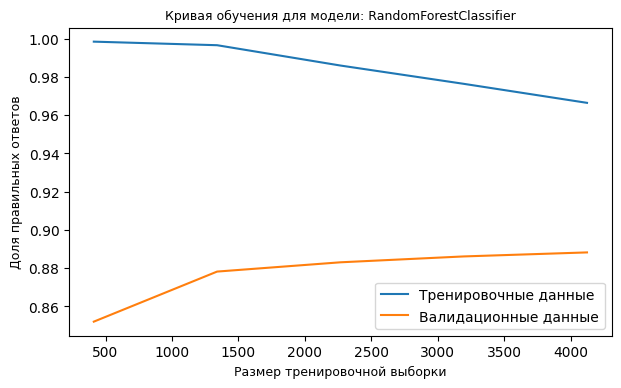

In [56]:
plot_learning_curve(rf, X_train, y_train)

#### 3.1.2 Бэггинг на деревьях (min_samples_leaf=1)

In [57]:
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=12, min_samples_leaf=1),
                               n_estimators=50,
                               random_state=0)
bagging_dt.fit(X_train, y_train)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt, X_train, X_test)

In [58]:
get_results_dict(0, '1_BaggingClassifier_dt', bagging_dt, y_train, y_test, y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba)

{'model_name': '1_BaggingClassifier_dt',
 'model_type': 'BaggingClassifier',
 'model': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=12),
                   n_estimators=50, random_state=0),
 'scores': [{'train_scores': {'train_accuracy': 0.9699369646032002,
    'train_precision': 0.9707653283187683,
    'train_recall': 0.9699403599386482,
    'train_f1_score': 0.9699238896284617,
    'train_roc_auc': 0.9980087759941701}},
  {'val_scores': {'val_accuracy': 0.8942774005819593,
    'val_precision': 0.895714081882732,
    'val_recall': 0.8942676682574712,
    'val_f1_score': 0.8941796622302612,
    'val_roc_auc': 0.9451074190249291}}]}

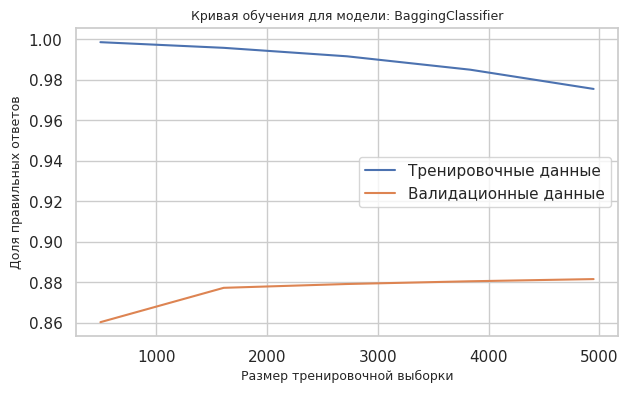

In [ ]:
plot_learning_curve(bagging_dt, X_train, y_train)

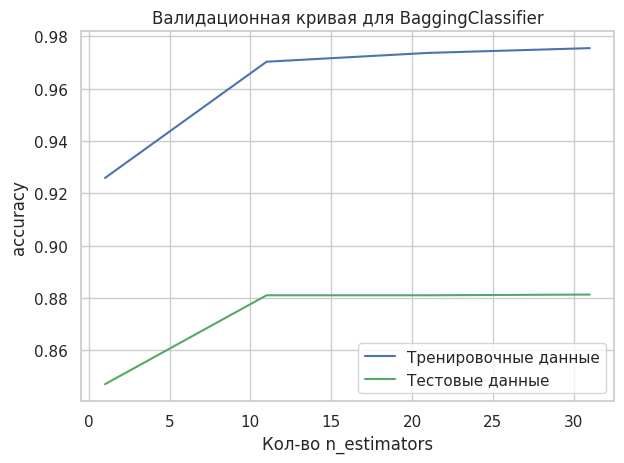

In [ ]:
val_curve_params(bagging_dt, X_train, y_train, "n_estimators", range(1,40,10), cv=3)

#### 3.1.3 Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков (max_features около 0.6 в BaggingClassifier)

In [59]:
bagging_dt_max_features = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                                            n_estimators=50,
                                            max_features=0.6,
                                            random_state=0)
bagging_dt_max_features.fit(X_train, y_train)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt_max_features, X_train, X_test)

In [60]:
get_results_dict(2, '2_BaggingClassifier_dt_max_features', bagging_dt_max_features, y_train, y_test, y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba)

{'model_name': '2_BaggingClassifier_dt_max_features',
 'model_type': 'BaggingClassifier',
 'model': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                   max_features=0.6, n_estimators=50, random_state=0),
 'scores': [{'train_scores': {'train_accuracy': 0.8868595442055923,
    'train_precision': 0.8894401614055241,
    'train_recall': 0.8868661244994902,
    'train_f1_score': 0.8866730263119333,
    'train_roc_auc': 0.9439704330586969}},
  {'val_scores': {'val_accuracy': 0.876495311994827,
    'val_precision': 0.8787064375299669,
    'val_recall': 0.8764829645660632,
    'val_f1_score': 0.8763122235798674,
    'val_roc_auc': 0.9355036372196407}}]}

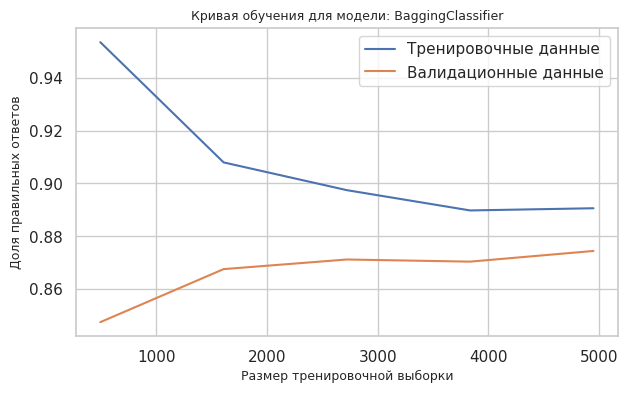

In [ ]:
plot_learning_curve(bagging_dt_max_features, X_train, y_train)

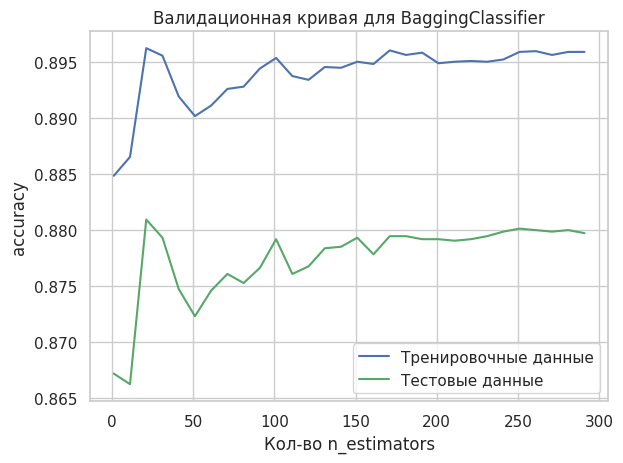

In [ ]:
val_curve_params(bagging_dt_max_features, X_train, y_train, "n_estimators", range(1,301,10), cv=3)

#### 3.1.4 Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)

In [17]:
boost_rf_sint_for_bagging = GradientBoostingClassifier(n_estimators=101,
                                                       max_depth=6,
                                                       random_state=0)

In [18]:
bagging_dt_boosting = BaggingClassifier(estimator=boost_rf_sint_for_bagging,
                                        n_estimators=10,
                                        random_state=0)
bagging_dt_boosting.fit(X_train, y_train)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt_boosting, X_train, X_test)

In [19]:
get_results_dict(3, '3_baggingclassifier_boosting', bagging_dt_boosting, y_train, y_test, y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba)

{'model_name': '3_baggingclassifier_boosting',
 'model_type': 'BaggingClassifier',
 'model': BaggingClassifier(estimator=GradientBoostingClassifier(max_depth=6,
                                                        n_estimators=101,
                                                        random_state=0),
                   random_state=0),
 'scores': [{'train_scores': {'train_accuracy': 0.9304956896551724,
    'train_precision': 0.9327950606943869,
    'train_recall': 0.9302469657289291,
    'train_f1_score': 0.9303727158200363,
    'train_roc_auc': 0.9887709035707537}},
  {'val_scores': {'val_accuracy': 0.8927801724137931,
    'val_precision': 0.8945015861928461,
    'val_recall': 0.8937987793257006,
    'val_f1_score': 0.8927664442215315,
    'val_roc_auc': 0.95013643103841}}]}

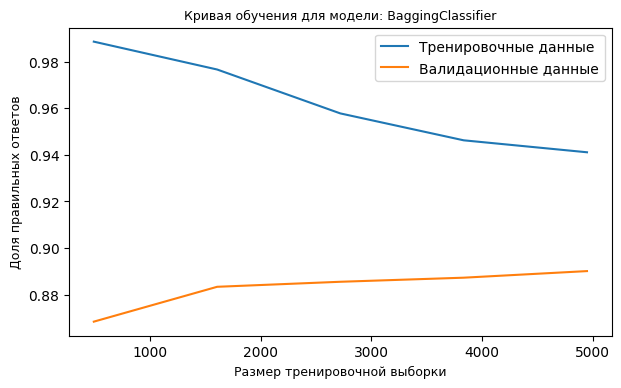

In [20]:
plot_learning_curve(bagging_dt_boosting, X_train, y_train)

In [22]:
# val_curve_params(bagging_dt_boosting, X_train, y_train, "n_estimators", range(1,300,3), cv=3)

#### 3.1.5 Бэггинг на логистических регрессиях

In [23]:
# Стандартизация
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [25]:
bagging_lr = BaggingClassifier(estimator=LogisticRegression(),
                                         n_estimators=40,
                                         random_state=0)
bagging_lr.fit(X_train_scaler, y_train)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_lr, X_train_scaler, X_test_scaler)

In [26]:
get_results_dict(4, '4_baggingclassifier_logreg', bagging_lr, y_train, y_test, y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba)

{'model_name': '4_baggingclassifier_logreg',
 'model_type': 'BaggingClassifier',
 'model': BaggingClassifier(estimator=LogisticRegression(), n_estimators=40,
                   random_state=0),
 'scores': [{'train_scores': {'train_accuracy': 0.8557381465517241,
    'train_precision': 0.8557406199983844,
    'train_recall': 0.8557188029729136,
    'train_f1_score': 0.8557270870493192,
    'train_roc_auc': 0.9293005115011552}},
  {'val_scores': {'val_accuracy': 0.8539870689655172,
    'val_precision': 0.8539454814642784,
    'val_recall': 0.8542198329358937,
    'val_f1_score': 0.8539514125721022,
    'val_roc_auc': 0.9288617886178863}}]}

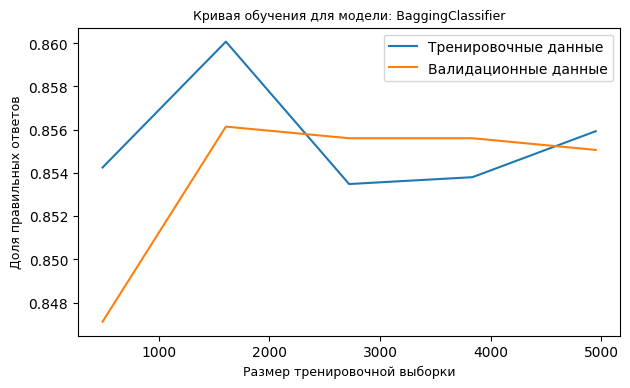

In [27]:
plot_learning_curve(bagging_lr, X_train_scaler, y_train)

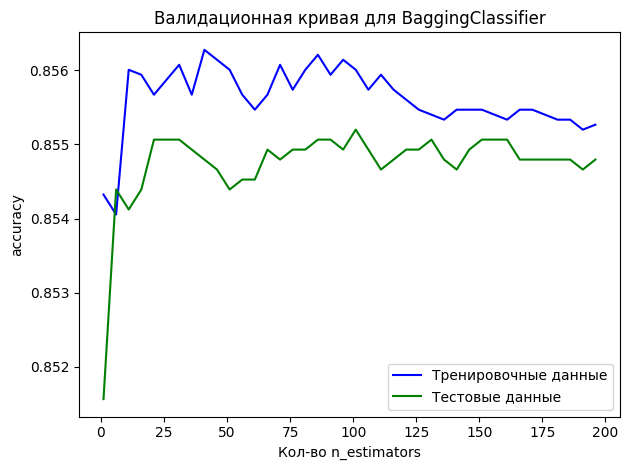

In [28]:
val_curve_params(bagging_lr, X_train_scaler, y_train, "n_estimators", range(1,200,5), cv=3)

In [61]:
results_df = get_results_df(results)
results_df

,Model Name,Model Type,Model,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score,train_roc_auc,val_roc_auc
0,3_baggingclassifier_boosting,BaggingClassifier,(([DecisionTreeRegressor(criterion='friedman_m...,0.930496,0.892780,0.932795,0.894502,0.930247,0.893799,0.930373,0.892766,0.988771,0.950136
1,4_baggingclassifier_logreg,BaggingClassifier,"(LogisticRegression(random_state=2087557356), ...",0.855738,0.853987,0.855741,0.853945,0.855719,0.854220,0.855727,0.853951,0.929301,0.928862
2,1_BaggingClassifier_dt,BaggingClassifier,"(DecisionTreeClassifier(max_depth=12, random_s...",0.969937,0.894277,0.970765,0.895714,0.969940,0.894268,0.969924,0.894180,0.998009,0.945107
3,2_BaggingClassifier_dt_max_features,BaggingClassifier,"(DecisionTreeClassifier(max_depth=6, random_st...",0.886860,0.876495,0.889440,0.878706,0.886866,0.876483,0.886673,0.876312,0.943970,0.935504


In [62]:
results_df[['Model Name', 'val_accuracy', 'val_f1_score', 'val_roc_auc']].sort_values(by='val_roc_auc', ascending=False)

,Model Name,val_accuracy,val_f1_score,val_roc_auc
0,3_baggingclassifier_boosting,0.892780,0.892766,0.950136
2,1_BaggingClassifier_dt,0.894277,0.894180,0.945107
3,2_BaggingClassifier_dt_max_features,0.876495,0.876312,0.935504
1,4_baggingclassifier_logreg,0.853987,0.853951,0.928862


#### Ответы на вопросы

__1) Какая из моделей имеет лучшее качество? С чем это связано?__

- Тут как как и в случае с синтетическими данными лидирует модель бэггинга на бустинге (n_estimators=10, однако если постивить значение 100 результат может сместиться в лучшую сторону), на равне ей стоит бэггинг на деревьях.

__2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка?__

- Беггинг на деревьях имеет самое высокое переобучение с заданными параметрами.

In [31]:
results_df_new = results_df[['Model Name', 'train_accuracy', 'val_accuracy']].copy()
results_df_new['diff_acc'] = results_df_new['train_accuracy'] - results_df_new['val_accuracy']

In [32]:
results_df_new.sort_values(by='diff_acc', ascending=False)

,Model Name,train_accuracy,val_accuracy,diff_acc
0,3_baggingclassifier_boosting,0.930496,0.892780,0.037716
1,4_baggingclassifier_logreg,0.855738,0.853987,0.001751


__3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?__

In [33]:
# Обучим бустинг с большим числом деревьев
boost_rf_sint_for_bagging_v2 = GradientBoostingClassifier(n_estimators=300,
                                                          max_depth=6,
                                                          random_state=0)

boost_rf_sint_for_bagging_v2.fit(X_train, y_train)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(boost_rf_sint_for_bagging_v2, X_train, X_test)

In [34]:
evaluate_model_classification(boost_rf_sint_for_bagging_v2, X_train, y_train, X_test, y_test)

--------------------------------------------------
Train Confusion Matrix:
[[3630   56]
 [  34 3704]]
--------------------------------------------------
Train Accuracy : 0.9879
Train Precision : 0.9848
Train Recall/Sensitivity/TPR : 0.9907
Train FPR (1 - Specificity): 0.0149
Train specificity : 0.9851
Train f1-score : 0.9878
--------------------------------------------------
Train ROC AUC : 0.9995
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[829 125]
 [ 74 828]]
--------------------------------------------------
Val Accuracy : 0.8928
Val Precision : 0.8690
Val Recall/Sensitivity/TPR : 0.9181
Val FPR (1 - Specificity) : 0.1312
Val specificity : 0.8688
Val f1-score : 0.8928
--------------------------------------------------
Val ROC AUC : 0.9453


In [35]:
# Обучим бэггинг на бустинге
bagging_dt_boosting_v2 = BaggingClassifier(estimator=boost_rf_sint_for_bagging_v2,
                                           n_estimators=10,
                                           random_state=0)
bagging_dt_boosting_v2.fit(X_train, y_train)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt_boosting_v2, X_train, X_test)

In [36]:
evaluate_model_classification(bagging_dt_boosting_v2, X_train, y_train, X_test, y_test)

--------------------------------------------------
Train Confusion Matrix:
[[3503  183]
 [  56 3682]]
--------------------------------------------------
Train Accuracy : 0.9678
Train Precision : 0.9504
Train Recall/Sensitivity/TPR : 0.9843
Train FPR (1 - Specificity): 0.0473
Train specificity : 0.9527
Train f1-score : 0.9670
--------------------------------------------------
Train ROC AUC : 0.9977
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[826 128]
 [ 60 842]]
--------------------------------------------------
Val Accuracy : 0.8987
Val Precision : 0.8658
Val Recall/Sensitivity/TPR : 0.9323
Val FPR (1 - Specificity) : 0.1320
Val specificity : 0.8680
Val f1-score : 0.8978
--------------------------------------------------
Val ROC AUC : 0.9483


- Безусловно бэггинг может  помогает уменьшить переобученность, особенно если используется большое количество деревьев. Т. к. усредненяет прогнозы базовых моделей, обученных на различных подмножествах данных.

__4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?__

В нашем случае по качеству модели выигрывает случайный лес - по метрике accuracy. Но результаты вполне сопоставимы

In [37]:
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=12, min_samples_leaf=1),
                               n_estimators=40,
                               random_state=0)
bagging_dt.fit(X_train, y_train)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt, X_train, X_test)

In [38]:
# Бэггинг на деревьях с сэмплированием признаков
evaluate_model_classification(bagging_dt, X_train, y_train, X_test, y_test)

--------------------------------------------------
Train Confusion Matrix:
[[3472  214]
 [  44 3694]]
--------------------------------------------------
Train Accuracy : 0.9652
Train Precision : 0.9419
Train Recall/Sensitivity/TPR : 0.9875
Train FPR (1 - Specificity): 0.0548
Train specificity : 0.9452
Train f1-score : 0.9642
--------------------------------------------------
Train ROC AUC : 0.9975
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[819 135]
 [ 62 840]]
--------------------------------------------------
Val Accuracy : 0.8939
Val Precision : 0.8585
Val Recall/Sensitivity/TPR : 0.9296
Val FPR (1 - Specificity) : 0.1385
Val specificity : 0.8615
Val f1-score : 0.8926
--------------------------------------------------
Val ROC AUC : 0.9478


In [39]:
rf = RandomForestClassifier(max_depth=12, random_state=0)
rf.fit(X_train, y_train)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(rf, X_train, X_test)

In [40]:
# Случайный лес
evaluate_model_classification(rf, X_train, y_train, X_test, y_test)

--------------------------------------------------
Train Confusion Matrix:
[[3393  293]
 [  72 3666]]
--------------------------------------------------
Train Accuracy : 0.9508
Train Precision : 0.9205
Train Recall/Sensitivity/TPR : 0.9792
Train FPR (1 - Specificity): 0.0740
Train specificity : 0.9260
Train f1-score : 0.9490
--------------------------------------------------
Train ROC AUC : 0.9947
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[817 137]
 [ 51 851]]
--------------------------------------------------
Val Accuracy : 0.8987
Val Precision : 0.8564
Val Recall/Sensitivity/TPR : 0.9412
Val FPR (1 - Specificity) : 0.1387
Val specificity : 0.8613
Val f1-score : 0.8968
--------------------------------------------------
Val ROC AUC : 0.9523


__5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?__

В нашем случае по качеству модели выигрывает бустинг на деревьях - по метрике accuracy.
- Бустинг фокусируется на улучшении модели за счет последовательного обучения слабых моделей.
- Бэггинг же просто усредняет прогнозы всех базовых моделей.

In [41]:
# Бэггинг на деревьях
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                                            n_estimators=40,
                                            random_state=0)
bagging_dt.fit(X_train, y_train)
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(bagging_dt, X_train, X_test)

In [42]:
evaluate_model_classification(bagging_dt, X_train, y_train, X_test, y_test)

--------------------------------------------------
Train Confusion Matrix:
[[3114  572]
 [ 190 3548]]
--------------------------------------------------
Train Accuracy : 0.8974
Train Precision : 0.8448
Train Recall/Sensitivity/TPR : 0.9425
Train FPR (1 - Specificity): 0.1388
Train specificity : 0.8612
Train f1-score : 0.8910
--------------------------------------------------
Train ROC AUC : 0.9584
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[805 149]
 [ 58 844]]
--------------------------------------------------
Val Accuracy : 0.8885
Val Precision : 0.8438
Val Recall/Sensitivity/TPR : 0.9328
Val FPR (1 - Specificity) : 0.1501
Val specificity : 0.8499
Val f1-score : 0.8861
--------------------------------------------------
Val ROC AUC : 0.9507


In [43]:
evaluate_model_classification(boost_rf_sint_for_bagging_v2, X_train, y_train, X_test, y_test)

--------------------------------------------------
Train Confusion Matrix:
[[3630   56]
 [  34 3704]]
--------------------------------------------------
Train Accuracy : 0.9879
Train Precision : 0.9848
Train Recall/Sensitivity/TPR : 0.9907
Train FPR (1 - Specificity): 0.0149
Train specificity : 0.9851
Train f1-score : 0.9878
--------------------------------------------------
Train ROC AUC : 0.9584
                                                  
                                                  
--------------------------------------------------
Val Confusion Matrix:
[[829 125]
 [ 74 828]]
--------------------------------------------------
Val Accuracy : 0.8928
Val Precision : 0.8690
Val Recall/Sensitivity/TPR : 0.9181
Val FPR (1 - Specificity) : 0.1312
Val specificity : 0.8688
Val f1-score : 0.8928
--------------------------------------------------
Val ROC AUC : 0.9507


## 4 Задание (2 балла) Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией. Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов. Получилось ли у вас победить библиотечные реализации на тестовых данных?

### 4.1 Синтетические данные

#### 4.1.1 CatBoost + Optyna

In [44]:
def objective(trial):
    model = CatBoostClassifier(
        cat_features=[],
        random_state=42,
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train_synthetic, y_train_synthetic)
    y_pred = model.predict(X_test_synthetic)
    return accuracy_score(y_test_synthetic, y_pred)

In [45]:
study = optuna.create_study(study_name="catboost", direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2024-01-31 12:07:54,568] A new study created in memory with name: catboost
[I 2024-01-31 12:08:01,359] Trial 0 finished with value: 0.8909 and parameters: {'iterations': 410, 'learning_rate': 0.00100872606712212, 'depth': 5, 'l2_leaf_reg': 0.0006273089970394099, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0004284618428880719, 'bagging_temperature': 1.4466015402715193, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 0 with value: 0.8909.
[I 2024-01-31 12:08:04,301] Trial 1 finished with value: 0.91905 and parameters: {'iterations': 185, 'learning_rate': 0.06372844134289628, 'depth': 9, 'l2_leaf_reg': 0.16962469382363815, 'bootstrap_type': 'Bayesian', 'random_strength': 3.403696500097168e-08, 'bagging_temperature': 6.230566012995511, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 1 with value: 0.91905.
[I 2024-01-31 12:08:12,016] Trial 2 finished with value: 0.90885 and parameters: {'iterations': 381, 'learning_rate': 0.002336336778160767, 'depth': 6, 'l2_leaf_reg': 1.11

In [46]:
print("Номер финишной итерации: ", len(study.trials))
print("Лучшая итерация:")
trial = study.best_trial
print("  Значение: ", trial.value)
print("  Параметры: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Номер финишной итерации:  47
Лучшая итерация:
  Значение:  0.923
  Параметры: 
    iterations: 952
    learning_rate: 0.0750705996397409
    depth: 4
    l2_leaf_reg: 6.477318083736294e-06
    bootstrap_type: Bayesian
    random_strength: 0.0007335756433374744
    bagging_temperature: 0.6258225791273075
    od_type: Iter
    od_wait: 14


In [47]:
n_splits = 3
clfs = []
scores = []

# параметры валидации, обучение будет идти на n_splits (фолдах)
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for num, (train_index, test_index) in enumerate(kf.split(X_synthetic, y_synthetic)):

    X_train, X_test = X_synthetic[train_index], X_synthetic[test_index]
    y_train, y_test = y_synthetic[train_index], y_synthetic[test_index]

    clf = CatBoostClassifier(cat_features=[],
                             random_state=42,
                             iterations=995,
                             learning_rate=0.01866037495549031,
                             depth=8,
                             l2_leaf_reg=0.11309661022499284,
                             bootstrap_type='Bayesian',
                             random_strength=0.008807465949659615,
                             bagging_temperature=0.056304723876412055,
                             od_type='Iter',
                             od_wait=12)

    clfs.append(clf)  # Сохраняем модель для дальнейшего использования

    clf.fit(X_train, y_train,
            eval_set=(X_test, y_test),
            verbose=150, plot=False)

    # инференс модели
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f'\n Accuracy: {score}')

    scores.append(score)
    print(f"fold: {num} acc: {score}")

# Считаем среднее и дисперсию по всем фолдам
print("mean accuracy score --", np.mean(scores, dtype="float16"), np.std(scores).round(4))

0:	learn: 0.6526474	test: 0.6526977	best: 0.6526977 (0)	total: 19.1ms	remaining: 18.9s
150:	learn: 0.1878835	test: 0.1890956	best: 0.1890956 (150)	total: 2.84s	remaining: 15.9s
300:	learn: 0.1745483	test: 0.1763583	best: 0.1763583 (300)	total: 5.54s	remaining: 12.8s
450:	learn: 0.1691827	test: 0.1721367	best: 0.1721367 (450)	total: 8.27s	remaining: 9.98s
600:	learn: 0.1656829	test: 0.1701140	best: 0.1701121 (599)	total: 12.4s	remaining: 8.14s
750:	learn: 0.1633037	test: 0.1692267	best: 0.1692223 (746)	total: 15.2s	remaining: 4.93s
900:	learn: 0.1613477	test: 0.1686645	best: 0.1686645 (900)	total: 17.9s	remaining: 1.87s
994:	learn: 0.1602265	test: 0.1684830	best: 0.1684801 (993)	total: 19.7s	remaining: 0us

bestTest = 0.1684801487
bestIteration = 993

Shrink model to first 994 iterations.

 Accuracy: 0.9203215935681286
fold: 0 acc: 0.9203215935681286
0:	learn: 0.6549429	test: 0.6548185	best: 0.6548185 (0)	total: 29.6ms	remaining: 29.4s
150:	learn: 0.1892352	test: 0.1903424	best: 0.19034

### 4.2 Кредитные данные

#### 4.2.1 CatBoost + Optyna

In [48]:
X_train = df_train.select_dtypes(['int64', 'float64']).drop(columns='y')
y_train = df_train.y

X_test = df_test.select_dtypes(['int64', 'float64']).drop(columns='y')
y_test = df_test.y

In [49]:
def objective(trial):
    model = CatBoostClassifier(
        cat_features=[],
        random_state=42,
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [50]:
study = optuna.create_study(study_name="catboost", direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2024-01-31 12:19:09,149] A new study created in memory with name: catboost
[I 2024-01-31 12:19:12,576] Trial 0 finished with value: 0.8873922413793104 and parameters: {'iterations': 592, 'learning_rate': 0.05240258791100744, 'depth': 8, 'l2_leaf_reg': 0.0011262442634645726, 'bootstrap_type': 'Bayesian', 'random_strength': 2.7106826117837887e-08, 'bagging_temperature': 2.804600308989844, 'od_type': 'Iter', 'od_wait': 12}. Best is trial 0 with value: 0.8873922413793104.
[I 2024-01-31 12:19:14,196] Trial 1 finished with value: 0.890625 and parameters: {'iterations': 316, 'learning_rate': 0.07759817403679642, 'depth': 8, 'l2_leaf_reg': 0.0022507156004910695, 'bootstrap_type': 'Bayesian', 'random_strength': 6.270811478396781e-07, 'bagging_temperature': 9.265163390979755, 'od_type': 'IncToDec', 'od_wait': 29}. Best is trial 1 with value: 0.890625.
[I 2024-01-31 12:19:15,265] Trial 2 finished with value: 0.8922413793103449 and parameters: {'iterations': 335, 'learning_rate': 0.027256686707

In [51]:
print("Номер финишной итерации: ", len(study.trials))
print("Лучшая итерация:")
trial = study.best_trial
print("  Значение: ", trial.value)
print("  Параметры: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Номер финишной итерации:  50
Лучшая итерация:
  Значение:  0.896551724137931
  Параметры: 
    iterations: 674
    learning_rate: 0.05467796375266597
    depth: 4
    l2_leaf_reg: 0.00017053078363260768
    bootstrap_type: Bayesian
    random_strength: 0.2786869239128554
    bagging_temperature: 6.6053725649642345
    od_type: Iter
    od_wait: 32


In [52]:
X_full = df.select_dtypes(['int64', 'float64']).drop(columns='y').values
y_full = df.y.values

In [53]:
n_splits = 3
clfs = []
scores = []

# параметры валидации, обучение будет идти на n_splits (фолдах)
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for num, (train_index, test_index) in enumerate(kf.split(X_full, y_full)):

    X_train, X_test = X_full[train_index], X_full[test_index]
    y_train, y_test = y_full[train_index], y_full[test_index]

    clf = CatBoostClassifier(cat_features=[],
                             random_state=42,
                             iterations=353,
                             learning_rate=0.03239576364272648,
                             depth=6,
                             l2_leaf_reg=2.8812770046923042e-08,
                             bootstrap_type='Bayesian',
                             random_strength=0.17430224622957147,
                             bagging_temperature=0.9340813632729648,
                             od_type='IncToDec',
                             od_wait=25)

    clfs.append(clf)  # Сохраняем модель для дальнейшего использования

    clf.fit(X_train, y_train,
            eval_set=(X_test, y_test),
            verbose=150, plot=False)

    # инференс модели
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f'\n Accuracy: {score}')

    scores.append(score)
    print(f"fold: {num} acc: {score}")

# Считаем среднее и дисперсию по всем фолдам
print("mean accuracy score --", np.mean(scores, dtype="float16"), np.std(scores).round(4))

0:	learn: 0.6574166	test: 0.6579902	best: 0.6579902 (0)	total: 3.26ms	remaining: 1.15s
150:	learn: 0.2276849	test: 0.2956491	best: 0.2950034 (140)	total: 458ms	remaining: 613ms
300:	learn: 0.1918898	test: 0.3006223	best: 0.2950034 (140)	total: 892ms	remaining: 154ms
352:	learn: 0.1812418	test: 0.3039509	best: 0.2950034 (140)	total: 1.04s	remaining: 0us

bestTest = 0.2950034226
bestIteration = 140

Shrink model to first 141 iterations.

 Accuracy: 0.8800904977375565
fold: 0 acc: 0.8800904977375565
0:	learn: 0.6601226	test: 0.6600326	best: 0.6600326 (0)	total: 3.02ms	remaining: 1.06s
150:	learn: 0.2342359	test: 0.2792028	best: 0.2792028 (150)	total: 461ms	remaining: 616ms
300:	learn: 0.1940465	test: 0.2824807	best: 0.2785558 (177)	total: 890ms	remaining: 154ms
352:	learn: 0.1829858	test: 0.2834831	best: 0.2785558 (177)	total: 1.04s	remaining: 0us

bestTest = 0.2785558215
bestIteration = 177

Shrink model to first 178 iterations.

 Accuracy: 0.8887811186550275
fold: 1 acc: 0.8887811186550

### Ответ на вопрос:

**Для синтетических данных:**

- Доля правильных ответов на тесте для самостоятельной реализации бустинга: `Accuracy_score: 0.913`
- Доля правильных ответов на тесте для CatBoost на Optyna: `Accuracy_score: 0.9225` (средний рез-т на кросс. вал. на всех данных и 3 фолдах: 0.9204)

**Для кредитных данных:**

- Доля правильных ответов на тесте для самостоятельной реализации бустинга: `Accuracy_score: 0.879`
- Доля правильных ответов на тесте для CatBoost на Optyna: `Accuracy_score: 0.8987` (средний рез-т на кросс. вал. на всех данных и 3 фолдах: 0.889)

Таким образом, библиотечная реализация дала результат ощутимо лучше.